In [13]:

#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch._C import NoneType
import torch
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, log_loss, f1_score
import os
import h5py
from torchsummary import summary
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
from sklearn.metrics import mean_squared_error, r2_score
nltk.download('punkt')
from torchvision import datasets, transforms, utils, models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split,Dataset
import torch.optim as optim
from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip -o archive.zip -d /content/archive1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#Fucntions
def load_data(data_dir,batch_size, val_split=0.1, test_split=0.1):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = ImageFolder(root=data_dir, transform=transform)
    dataset_size = len(dataset)
    val_size = int(val_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - val_size - test_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, dataset

def train_test(train_loader, val_loader, test_loader, model, optimizer, criterion, device):
    train_losses = []
    val_losses = []
    test_losses = []

    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    num_epochs = 10

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print('Epoch:', epoch+1, 'Train Loss:', train_losses[-1], 'Train Accuracy:', train_accuracies[-1], 'Val Loss:', val_losses[-1], 'Val Accuracy:', val_accuracies[-1])

        scheduler.step()

    true_labels = []
    pred_labels = []
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(100 * correct_test / total_test)

        avg_test_loss = test_loss / len(test_loader)
        precision = precision_score(true_labels, pred_labels, average='macro')
        recall = recall_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        accuracy = accuracy_score(true_labels, pred_labels)
        print("Accuracy: ", accuracy * 100)
        print("Test Loss: ", avg_test_loss)
        print("Precision: ", precision*100)
        print("Recall: ", recall*100)
        print("F1 Score: ", f1*100)

        print('Test Loss: ',test_losses[-1], 'Test Accuracy: ',test_accuracies[-1])

    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels

def plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss', linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.345687571913004 Train Accuracy: 44.86074270557029 Val Loss: 1.1258059640725453 Val Accuracy: 51.9893899204244
Epoch: 2 Train Loss: 0.9845355326930681 Train Accuracy: 60.80901856763926 Val Loss: 0.8387856185436249 Val Accuracy: 66.57824933687003
Epoch: 3 Train Loss: 0.7357945516705513 Train Accuracy: 74.03846153846153 Val Loss: 0.6962458888689677 Val Accuracy: 71.88328912466844
Epoch: 4 Train Loss: 0.5109308479974667 Train Accuracy: 84.74801061007958 Val Loss: 0.4341464142004649 Val Accuracy: 84.61538461538461
Epoch: 5 Train Loss: 0.3309237357849876 Train Accuracy: 89.9867374005305 Val Loss: 0.38639574746290845 Val Accuracy: 83.0238726790451
Epoch: 6 Train Loss: 0.25468606734648347 Train Accuracy: 92.67241379310344 Val Loss: 0.30394938588142395 Val Accuracy: 89.92042440318302
Epoch: 7 Train Loss: 0.23787523293867707 Train Accuracy: 93.00397877984085 Val Loss: 0.31913089007139206 Val Accura

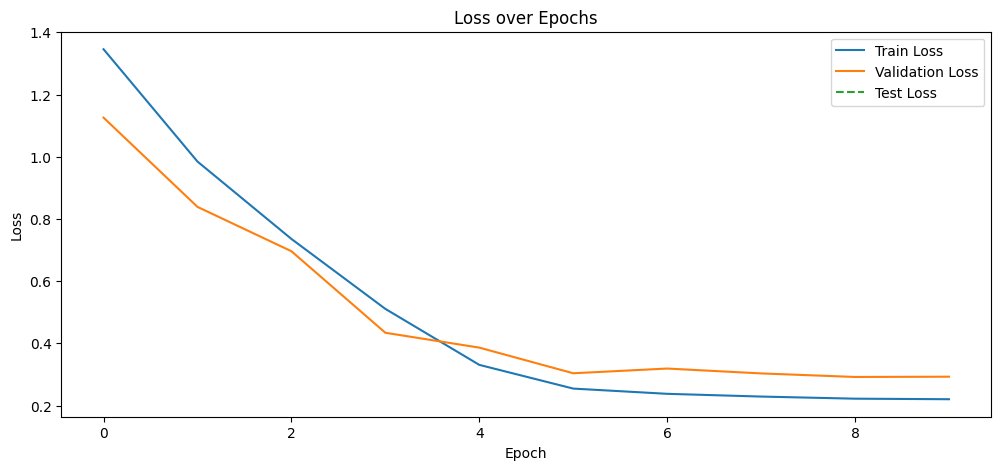

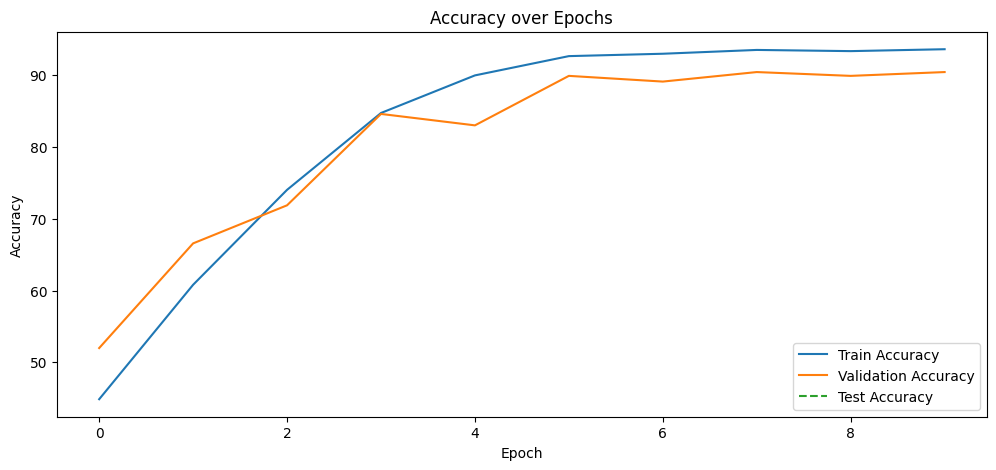

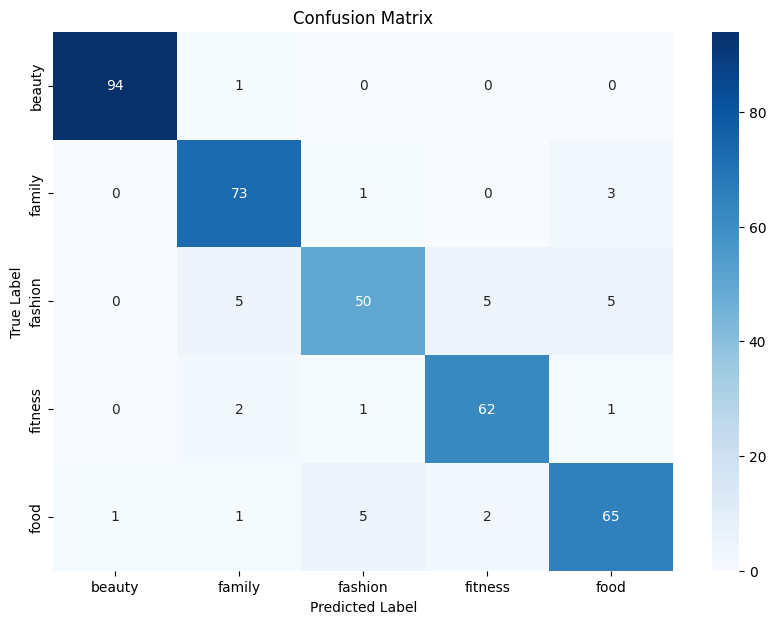

{'train_losses': [1.345687571913004, 0.9845355326930681, 0.7357945516705513, 0.5109308479974667, 0.3309237357849876, 0.25468606734648347, 0.23787523293867707, 0.22904582818349203, 0.2222459364371995, 0.22050342491517463], 'train_accuracies': [44.86074270557029, 60.80901856763926, 74.03846153846153, 84.74801061007958, 89.9867374005305, 92.67241379310344, 93.00397877984085, 93.53448275862068, 93.36870026525199, 93.63395225464191], 'val_losses': [1.1258059640725453, 0.8387856185436249, 0.6962458888689677, 0.4341464142004649, 0.38639574746290845, 0.30394938588142395, 0.31913089007139206, 0.3034667695562045, 0.29204946011304855, 0.29288599143425625], 'val_accuracies': [51.9893899204244, 66.57824933687003, 71.88328912466844, 84.61538461538461, 83.0238726790451, 89.92042440318302, 89.12466843501326, 90.45092838196287, 89.92042440318302, 90.45092838196287], 'test_losses': [0.3002360636989276], 'test_accuracies': [91.24668435013263]}
Running experiment with batch size 64, optimizer SGD, and L2 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  48.01061007957559
Test Loss:  1.5873957872390747
Precision:  44.159674548690575
Recall:  47.932325127447086
F1 Score:  38.562036254343944
Test Loss:  1.5873957872390747 Test Accuracy:  48.0106100795756


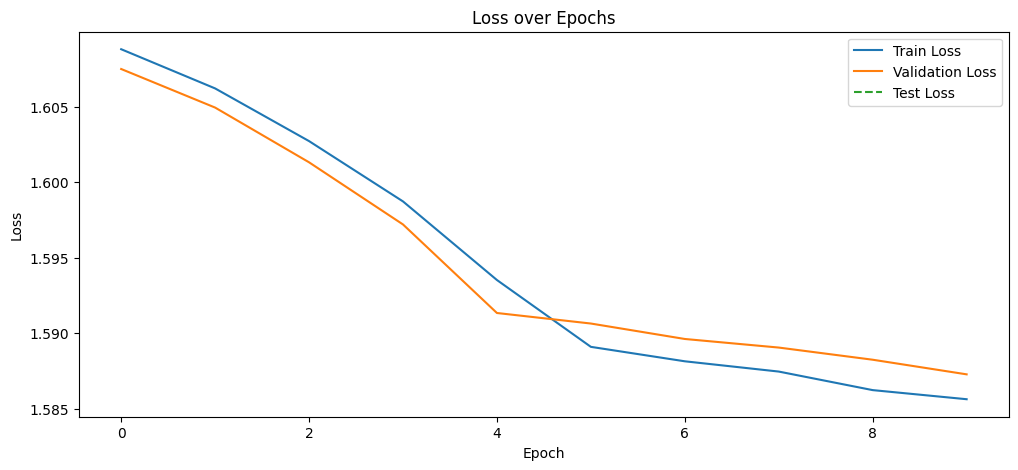

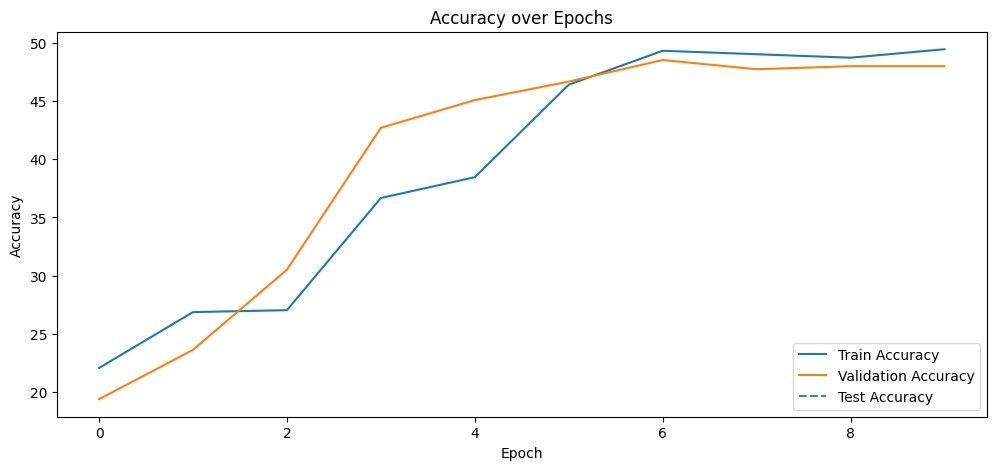

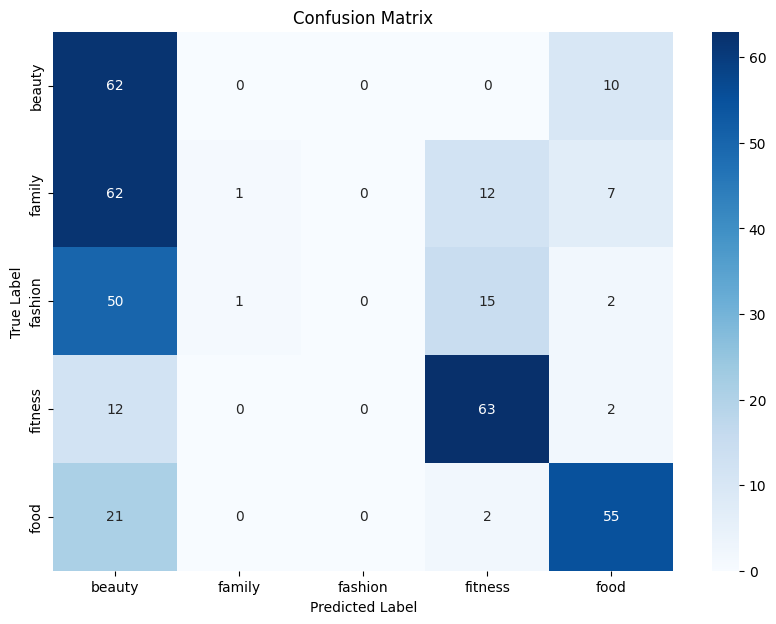

{'train_losses': [1.6088057557741802, 1.6062107632557552, 1.60272270689408, 1.5987296650807064, 1.5935262913505237, 1.5891019304593403, 1.5881456111868222, 1.587465633948644, 1.586237755914529, 1.5856347903609276], 'train_accuracies': [22.049071618037136, 26.856763925729442, 27.022546419098145, 36.6710875331565, 38.46153846153846, 46.41909814323608, 49.3368700265252, 49.03846153846154, 48.740053050397876, 49.46949602122016], 'val_losses': [1.6074958443641663, 1.6049422423044841, 1.601318895816803, 1.5972050428390503, 1.591343104839325, 1.590645670890808, 1.589623212814331, 1.5890548427899678, 1.5882497628529866, 1.587281624476115], 'val_accuracies': [19.363395225464192, 23.607427055702917, 30.50397877984085, 42.705570291777185, 45.09283819628647, 46.684350132625994, 48.54111405835544, 47.745358090185675, 48.0106100795756, 48.0106100795756], 'test_losses': [1.5873957872390747], 'test_accuracies': [48.0106100795756]}
Running experiment with batch size 64, optimizer RMSprop, and L2 penalt

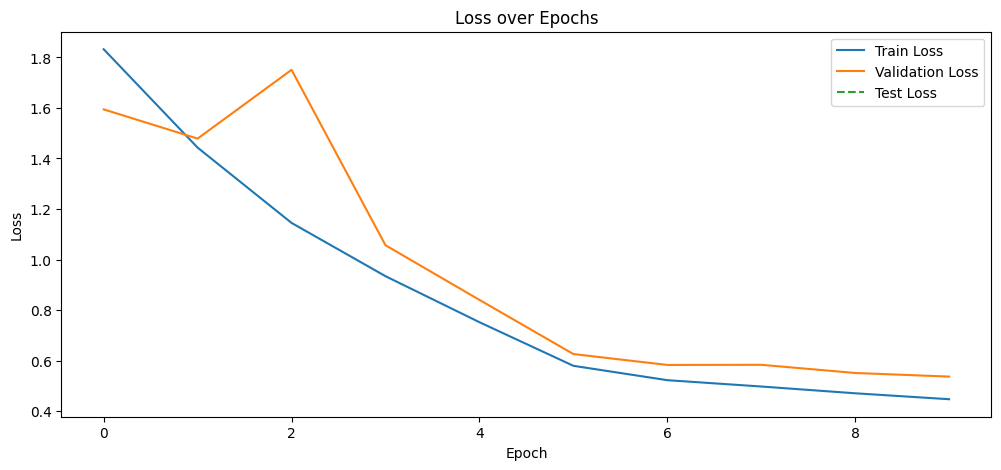

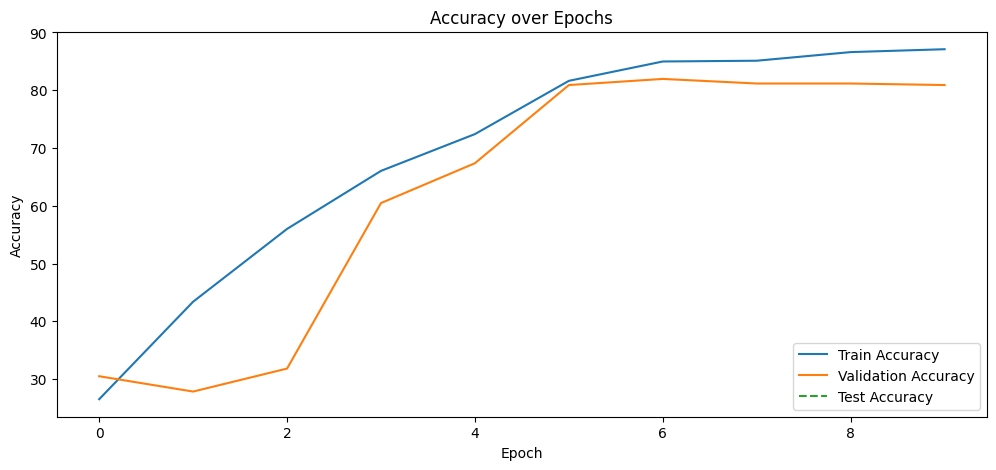

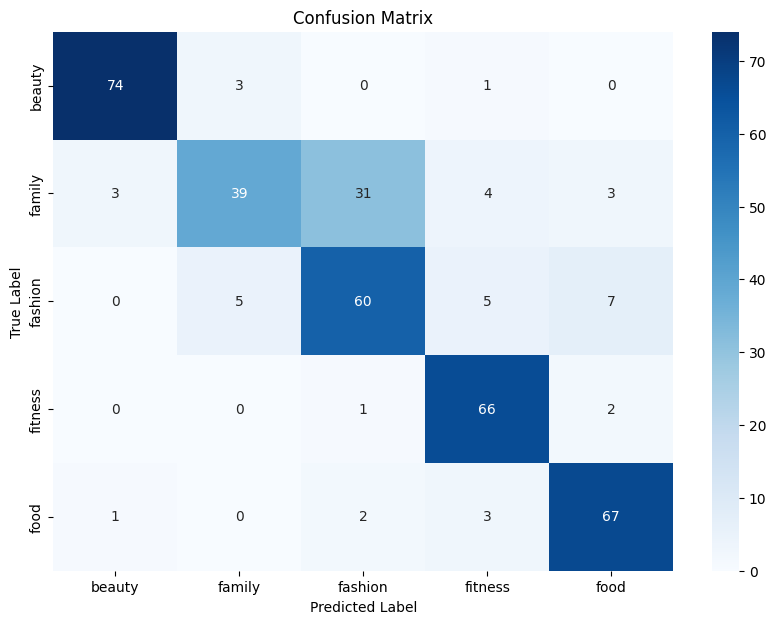

{'train_losses': [1.8323401436209679, 1.443033625682195, 1.1451650820672512, 0.9344097500046095, 0.75232393356661, 0.5797939592351516, 0.522950359309713, 0.4978910870850086, 0.4710712321102619, 0.4475988723958532], 'train_accuracies': [26.52519893899204, 43.40185676392573, 56.00132625994695, 66.04774535809018, 72.41379310344827, 81.63129973474801, 84.98010610079575, 85.11273209549071, 86.60477453580901, 87.10212201591511], 'val_losses': [1.5943053166071575, 1.4787399967511494, 1.7508981029192607, 1.0567906598250072, 0.8406387468179067, 0.6263552705446879, 0.5832104533910751, 0.5837621241807938, 0.5513977160056432, 0.5371294567982355], 'val_accuracies': [30.50397877984085, 27.851458885941646, 31.83023872679045, 60.47745358090186, 67.37400530503979, 80.90185676392574, 81.96286472148542, 81.16710875331565, 81.16710875331565, 80.90185676392574], 'test_losses': [0.5259805421034495], 'test_accuracies': [81.16710875331565]}


In [ ]:
#Simple Net
class CNN1(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/My Drive/archive1'

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = CNN1(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.5592243919769924 Train Accuracy: 25.69628647214854 Val Loss: 2.403581360975901 Val Accuracy: 19.363395225464192
Epoch: 2 Train Loss: 1.4437808617949486 Train Accuracy: 36.40583554376658 Val Loss: 1.2501291036605835 Val Accuracy: 47.214854111405835
Epoch: 3 Train Loss: 1.1446100684503715 Train Accuracy: 51.12732095490716 Val Loss: 0.9953224162260691 Val Accuracy: 61.53846153846154
Epoch: 4 Train Loss: 0.7163329540441433 Train Accuracy: 73.77320954907162 Val Loss: 0.38536561528841656 Val Accuracy: 88.3289124668435
Epoch: 5 Train Loss: 0.36615570572515327 Train Accuracy: 87.59946949602121 Val Loss: 0.37269043425718945 Val Accuracy: 89.92042440318302
Epoch: 6 Train Loss: 0.2941143273686369 Train Accuracy: 90.91511936339522 Val Loss: 0.29995008806387585 Val Accuracy: 90.9814323607427
Epoch: 7 Train Loss: 0.2690300401300192 Train Accuracy: 91.01458885941645 Val Loss: 0.30158016333977383 Val Acc

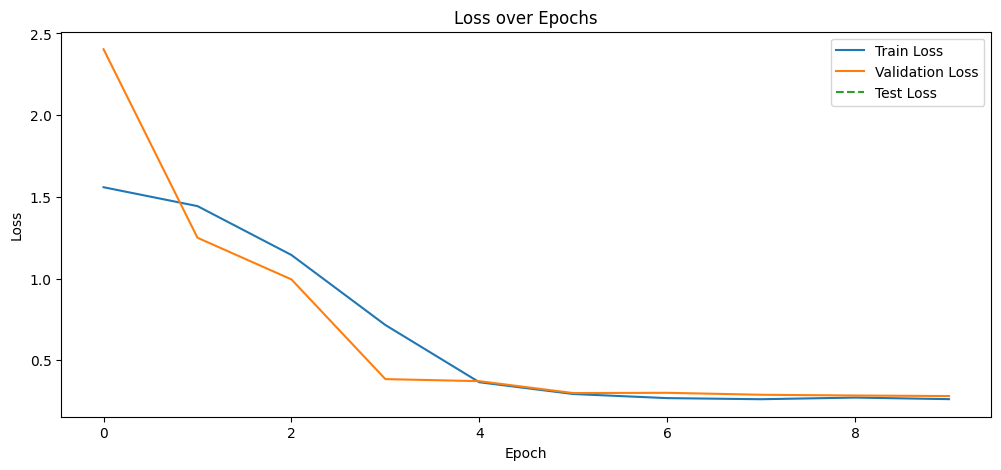

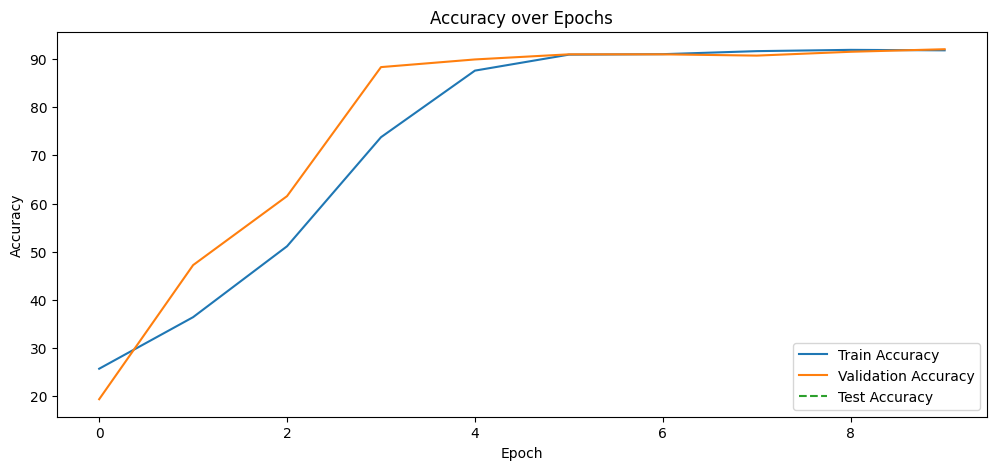

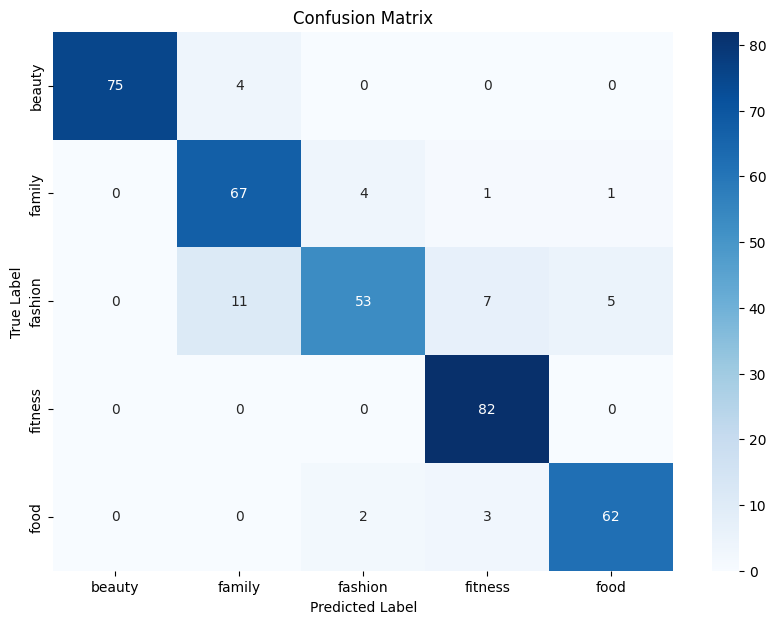

{'train_losses': [1.5592243919769924, 1.4437808617949486, 1.1446100684503715, 0.7163329540441433, 0.36615570572515327, 0.2941143273686369, 0.2690300401300192, 0.26227474957704544, 0.2723045985524853, 0.2627620765318473], 'train_accuracies': [25.69628647214854, 36.40583554376658, 51.12732095490716, 73.77320954907162, 87.59946949602121, 90.91511936339522, 91.01458885941645, 91.64456233421751, 91.90981432360742, 91.8103448275862], 'val_losses': [2.403581360975901, 1.2501291036605835, 0.9953224162260691, 0.38536561528841656, 0.37269043425718945, 0.29995008806387585, 0.30158016333977383, 0.28956706325213116, 0.2849445665876071, 0.2817090501387914], 'val_accuracies': [19.363395225464192, 47.214854111405835, 61.53846153846154, 88.3289124668435, 89.92042440318302, 90.9814323607427, 90.9814323607427, 90.71618037135279, 91.51193633952255, 92.04244031830238], 'test_losses': [0.3486437698205312], 'test_accuracies': [89.92042440318302]}
Running experiment with batch size 64, optimizer SGD, and L2 p

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  26.25994694960212
Test Loss:  1.604221224784851
Precision:  18.905919661733613
Recall:  25.590500641848525
F1 Score:  15.490683229813666
Test Loss:  1.604221224784851 Test Accuracy:  26.25994694960212


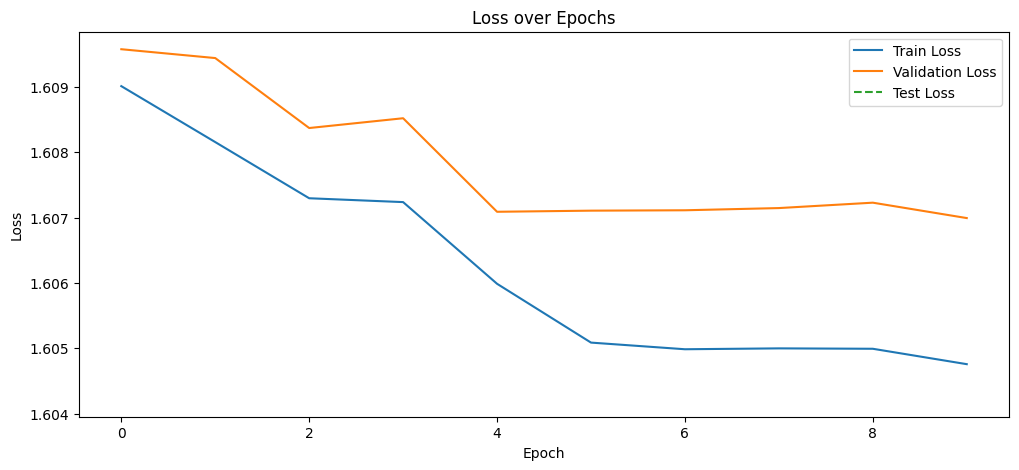

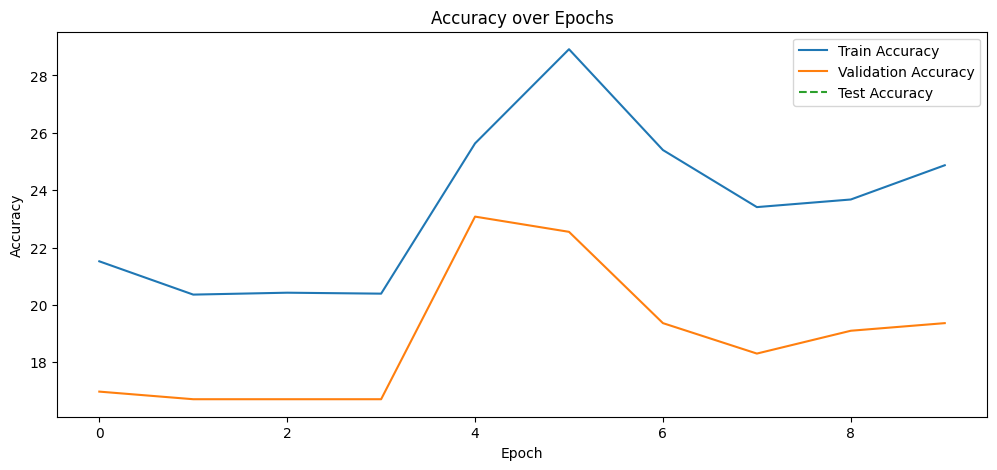

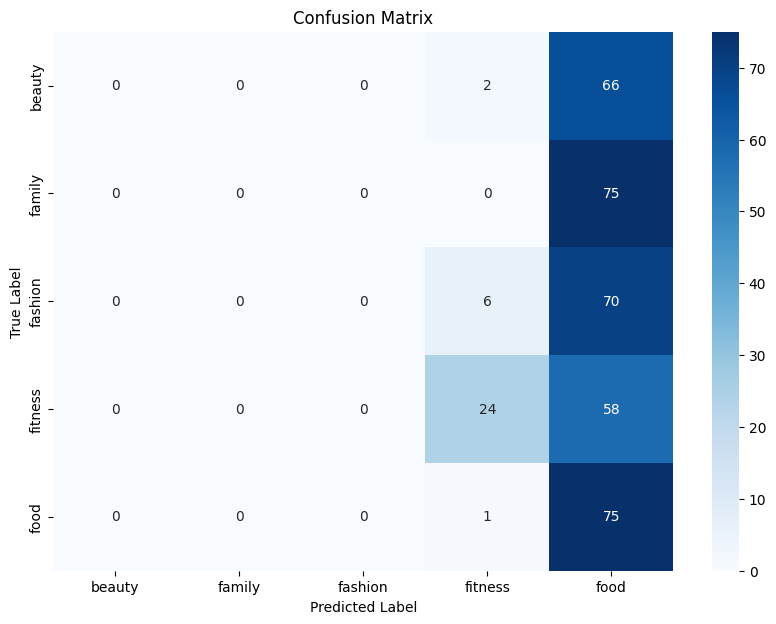

{'train_losses': [1.6090120499332745, 1.6081561719377835, 1.6072965785861015, 1.6072376171747844, 1.605987640718619, 1.6050877099235852, 1.6049859498937924, 1.6049993361035984, 1.6049932911992073, 1.6047575895984967], 'train_accuracies': [21.518567639257295, 20.358090185676392, 20.424403183023873, 20.391246684350133, 25.629973474801062, 28.912466843501328, 25.397877984084882, 23.408488063660478, 23.6737400530504, 24.867374005305038], 'val_losses': [1.6095770796140034, 1.6094417572021484, 1.6083711981773376, 1.6085209051767986, 1.6070895791053772, 1.6071067253748577, 1.6071126063664753, 1.6071462829907734, 1.6072288751602173, 1.6069932182629902], 'val_accuracies': [16.97612732095491, 16.71087533156499, 16.71087533156499, 16.71087533156499, 23.076923076923077, 22.546419098143236, 19.363395225464192, 18.30238726790451, 19.09814323607427, 19.363395225464192], 'test_losses': [1.604221224784851], 'test_accuracies': [26.25994694960212]}
Running experiment with batch size 64, optimizer RMSprop

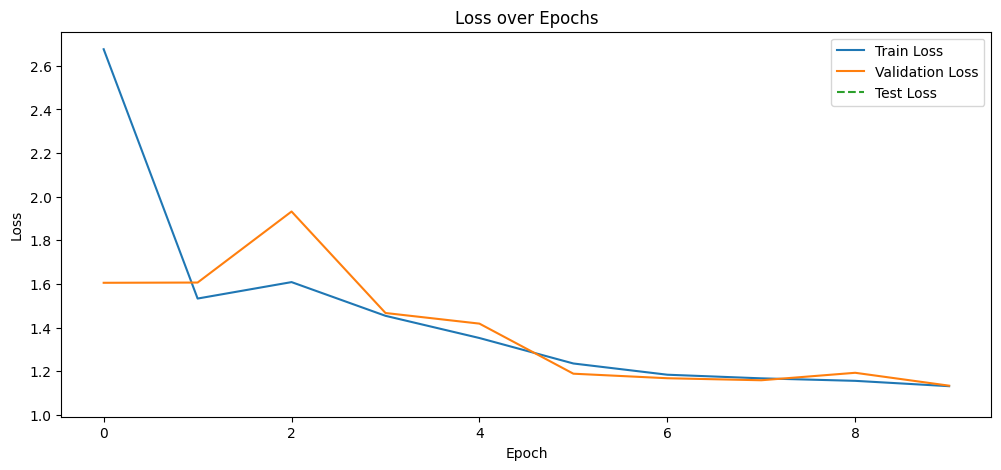

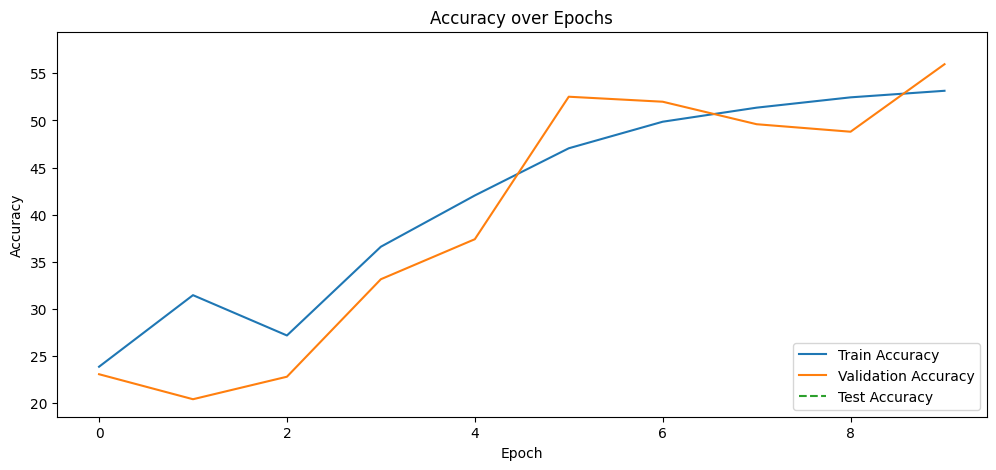

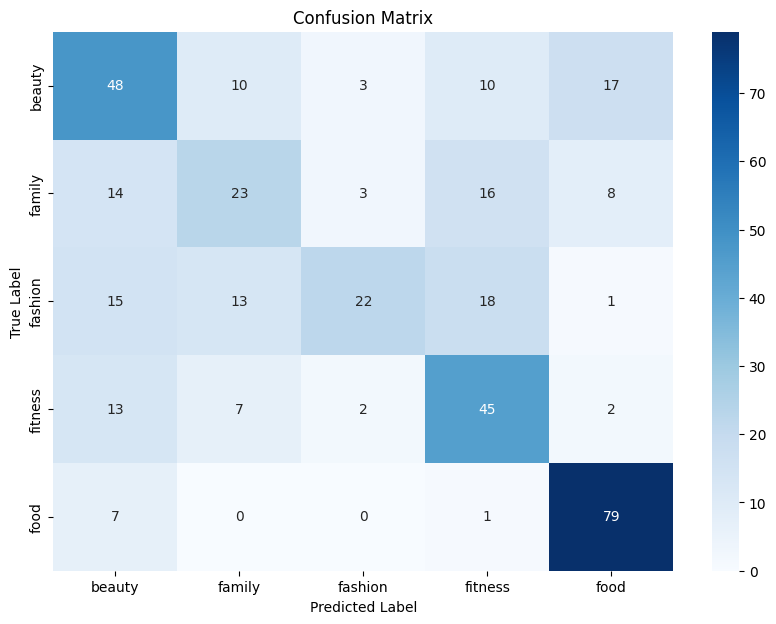

{'train_losses': [2.6761292840043702, 1.5333707258105278, 1.6087592119971912, 1.454244223733743, 1.3524457514286041, 1.23576308041811, 1.184296724696954, 1.167687254647414, 1.1562004449466865, 1.1317227557301521], 'train_accuracies': [23.872679045092838, 31.46551724137931, 27.188328912466844, 36.60477453580902, 42.04244031830239, 47.04907161803713, 49.86737400530504, 51.35941644562334, 52.45358090185676, 53.149867374005304], 'val_losses': [1.605621616045634, 1.606717824935913, 1.9323174357414246, 1.4671534895896912, 1.4184527397155762, 1.1889568567276, 1.1681467096010845, 1.1588844855626423, 1.1931152939796448, 1.13401460647583], 'val_accuracies': [23.076923076923077, 20.424403183023873, 22.811671087533156, 33.15649867374005, 37.40053050397878, 52.51989389920424, 51.9893899204244, 49.60212201591512, 48.80636604774536, 55.96816976127321], 'test_losses': [1.0719650586446126], 'test_accuracies': [57.55968169761273]}


In [ ]:
#Deeper Net
class CNN2(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/My Drive/archive1'

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = CNN2(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.6901244384547074 Train Accuracy: 52.785145888594165 Val Loss: 0.9527212679386139 Val Accuracy: 66.3129973474801
Epoch: 2 Train Loss: 0.36349519652624923 Train Accuracy: 88.22944297082228 Val Loss: 0.2877451578776042 Val Accuracy: 90.18567639257294
Epoch: 3 Train Loss: 0.2642412269487977 Train Accuracy: 91.04774535809018 Val Loss: 0.55430635313193 Val Accuracy: 75.59681697612731
Epoch: 4 Train Loss: 0.2589601438182096 Train Accuracy: 91.57824933687003 Val Loss: 0.39478130141894024 Val Accuracy: 88.85941644562334
Epoch: 5 Train Loss: 0.24112873834868273 Train Accuracy: 91.77718832891247 Val Loss: 0.3749151974916458 Val Accuracy: 89.92042440318302
Epoch: 6 Train Loss: 0.1392498358618468 Train Accuracy: 95.35809018567639 Val Loss: 0.2356762836376826 Val Accuracy: 92.3076923076923
Epoch: 7 Train Loss: 0.11370731556477646 Train Accuracy: 96.08753315649868 Val Loss: 0.243728997806708 Val Accurac

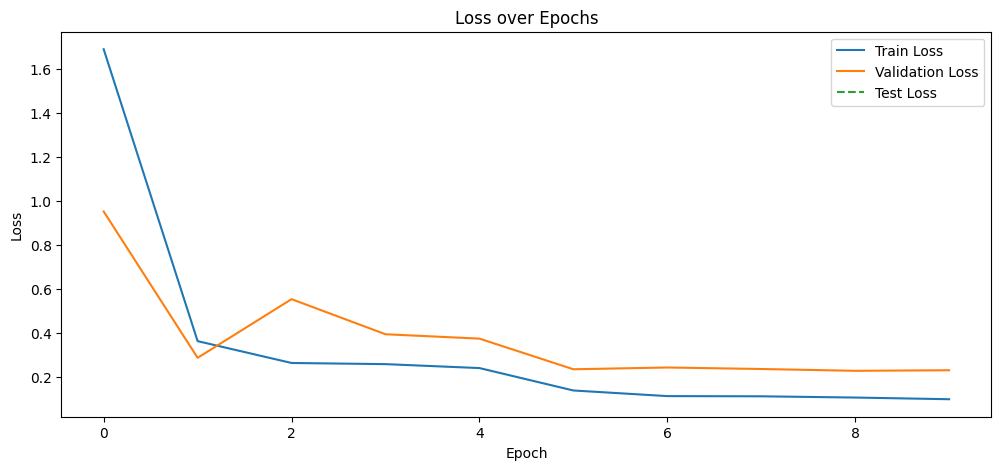

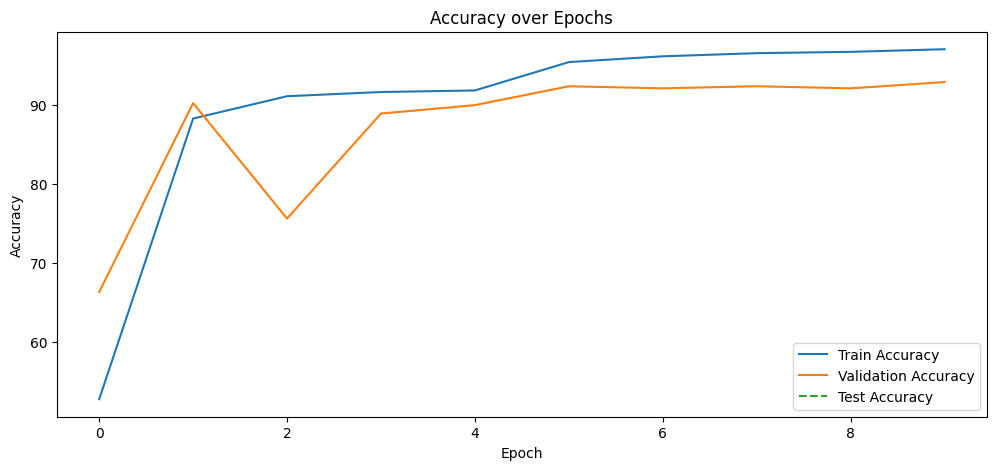

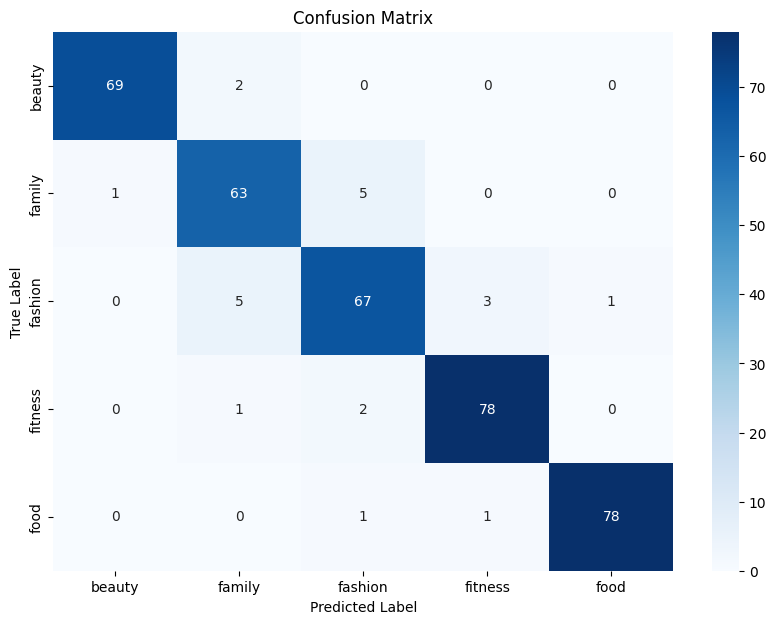

{'train_losses': [1.6901244384547074, 0.36349519652624923, 0.2642412269487977, 0.2589601438182096, 0.24112873834868273, 0.1392498358618468, 0.11370731556477646, 0.11279440888514121, 0.10713570091562967, 0.09952451350788276], 'train_accuracies': [52.785145888594165, 88.22944297082228, 91.04774535809018, 91.57824933687003, 91.77718832891247, 95.35809018567639, 96.08753315649868, 96.48541114058355, 96.65119363395226, 96.98275862068965], 'val_losses': [0.9527212679386139, 0.2877451578776042, 0.55430635313193, 0.39478130141894024, 0.3749151974916458, 0.2356762836376826, 0.243728997806708, 0.23687744637330374, 0.22863499571879706, 0.231180469195048], 'val_accuracies': [66.3129973474801, 90.18567639257294, 75.59681697612731, 88.85941644562334, 89.92042440318302, 92.3076923076923, 92.04244031830238, 92.3076923076923, 92.04244031830238, 92.83819628647215], 'test_losses': [0.16731018821398416], 'test_accuracies': [94.16445623342175]}


In [ ]:
#Batch Normalization

class CNN3(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/archive1'

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = CNN3(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.349759745101134 Train Accuracy: 48.5079575596817 Val Loss: 1.3209790587425232 Val Accuracy: 46.94960212201592
Epoch: 2 Train Loss: 1.1506730914115906 Train Accuracy: 58.222811671087534 Val Loss: 1.4011301795641582 Val Accuracy: 39.787798408488065
Epoch: 3 Train Loss: 1.0668766237795353 Train Accuracy: 62.0026525198939 Val Loss: 1.095734973748525 Val Accuracy: 49.07161803713528
Epoch: 4 Train Loss: 0.9876744300127029 Train Accuracy: 65.9814323607427 Val Loss: 1.119749555985133 Val Accuracy: 55.70291777188329
Epoch: 5 Train Loss: 0.9115712282558283 Train Accuracy: 69.66180371352785 Val Loss: 0.9612436989943186 Val Accuracy: 63.6604774535809
Epoch: 6 Train Loss: 0.8527118812004725 Train Accuracy: 72.31432360742706 Val Loss: 0.8173906008402506 Val Accuracy: 74.27055702917772
Epoch: 7 Train Loss: 0.8432737315694491 Train Accuracy: 72.41379310344827 Val Loss: 0.80377530058225 Val Accuracy: 74.0

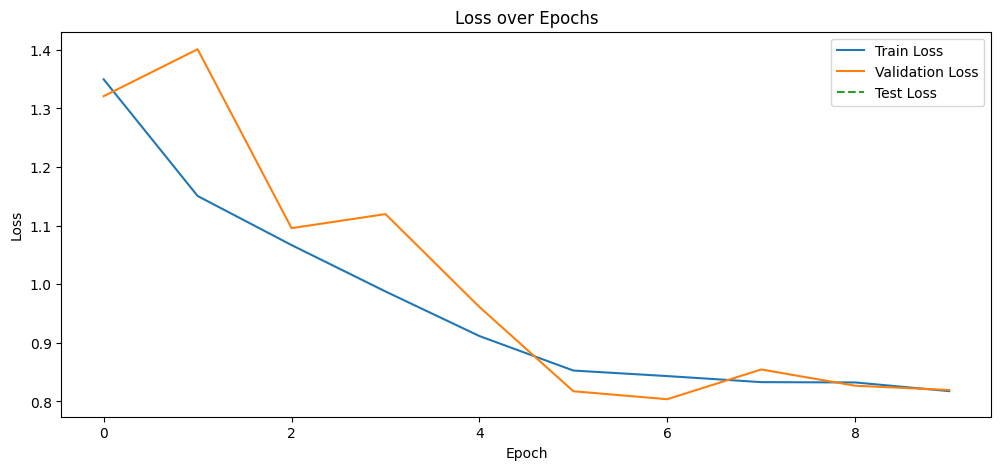

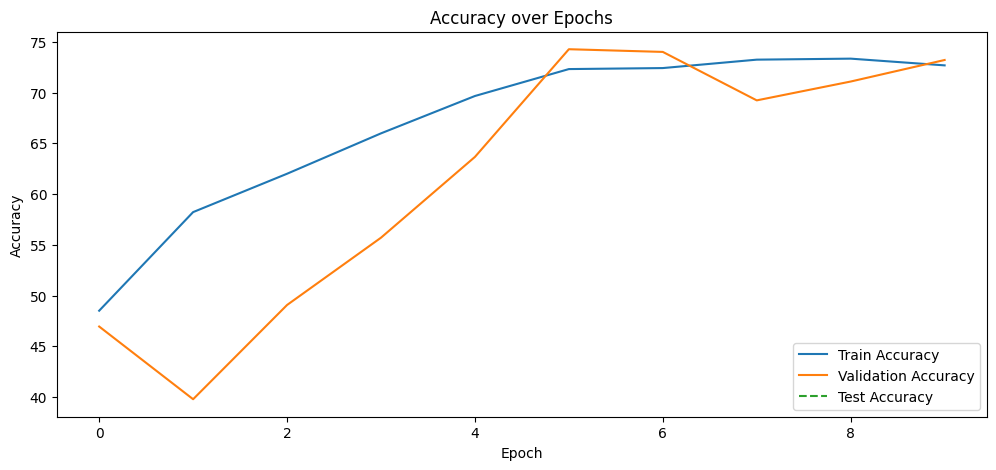

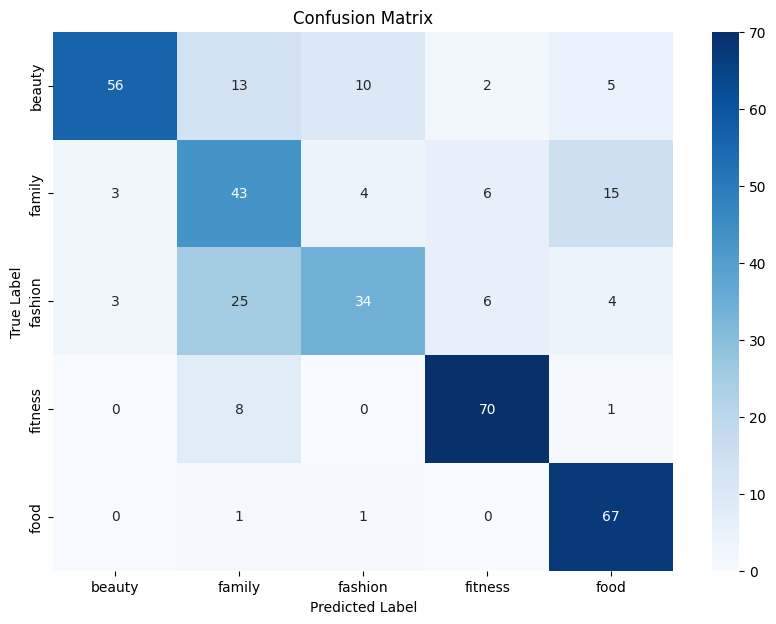

{'train_losses': [1.349759745101134, 1.1506730914115906, 1.0668766237795353, 0.9876744300127029, 0.9115712282558283, 0.8527118812004725, 0.8432737315694491, 0.8329467698931694, 0.8324180965622267, 0.8175914163390795], 'train_accuracies': [48.5079575596817, 58.222811671087534, 62.0026525198939, 65.9814323607427, 69.66180371352785, 72.31432360742706, 72.41379310344827, 73.24270557029178, 73.342175066313, 72.6790450928382], 'val_losses': [1.3209790587425232, 1.4011301795641582, 1.095734973748525, 1.119749555985133, 0.9612436989943186, 0.8173906008402506, 0.80377530058225, 0.8545460204283396, 0.8268039027849833, 0.8194913665453593], 'val_accuracies': [46.94960212201592, 39.787798408488065, 49.07161803713528, 55.70291777188329, 63.6604774535809, 74.27055702917772, 74.0053050397878, 69.23076923076923, 71.08753315649868, 73.20954907161804], 'test_losses': [0.854873925447464], 'test_accuracies': [71.61803713527851]}
Running experiment with batch size 64, optimizer SGD, and L2 penalty 0.001
Epo

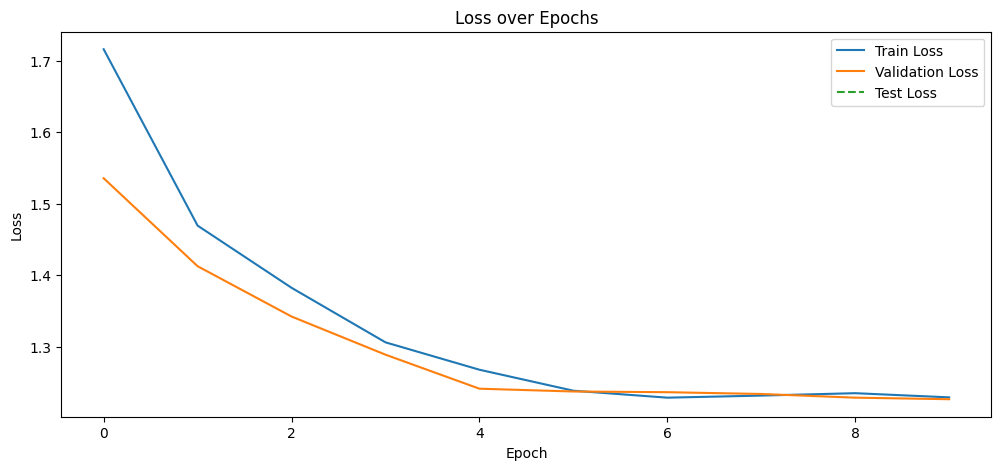

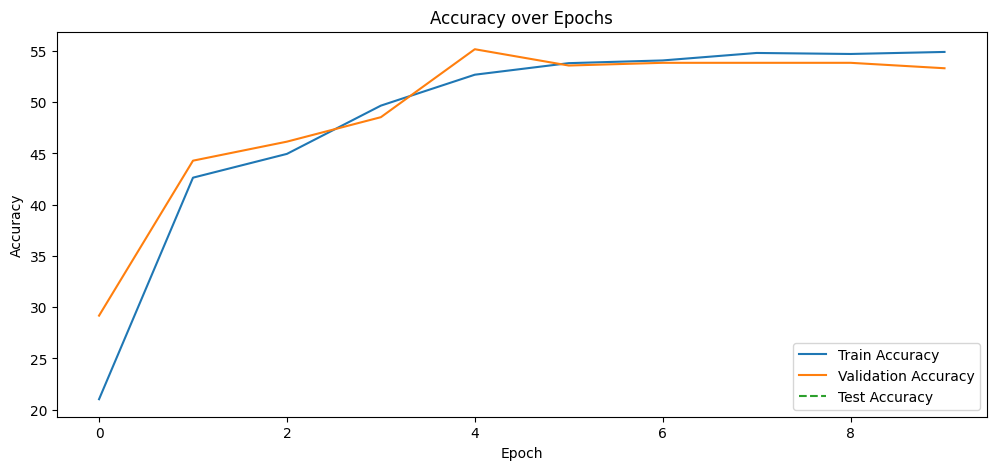

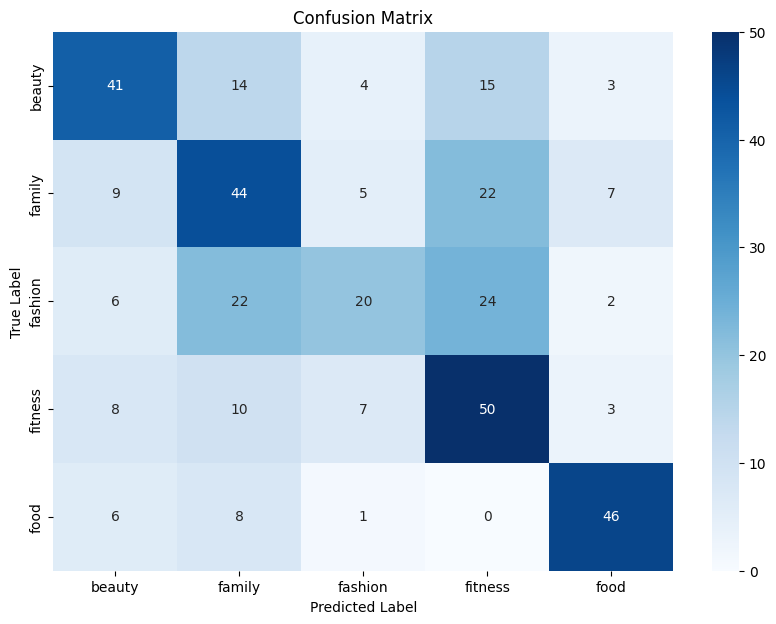

{'train_losses': [1.7160806208848953, 1.4692171265681584, 1.3821933989723523, 1.3058622802297275, 1.2675394862890244, 1.2381701096892357, 1.2284471342960994, 1.2313458720842998, 1.2347044597069423, 1.2288683503866196], 'train_accuracies': [21.021220159151195, 42.63925729442971, 44.96021220159151, 49.6684350132626, 52.685676392572944, 53.812997347480106, 54.07824933687002, 54.80769230769231, 54.708222811671085, 54.90716180371353], 'val_losses': [1.5354881683985393, 1.4123992125193279, 1.342003325621287, 1.2885984182357788, 1.240986963113149, 1.2370766003926594, 1.2361099123954773, 1.233599106470744, 1.228440523147583, 1.2262659867604573], 'val_accuracies': [29.177718832891248, 44.29708222811671, 46.15384615384615, 48.54111405835544, 55.172413793103445, 53.58090185676392, 53.84615384615385, 53.84615384615385, 53.84615384615385, 53.315649867374006], 'test_losses': [1.2643051942189534], 'test_accuracies': [53.315649867374006]}
Running experiment with batch size 64, optimizer RMSprop, and L

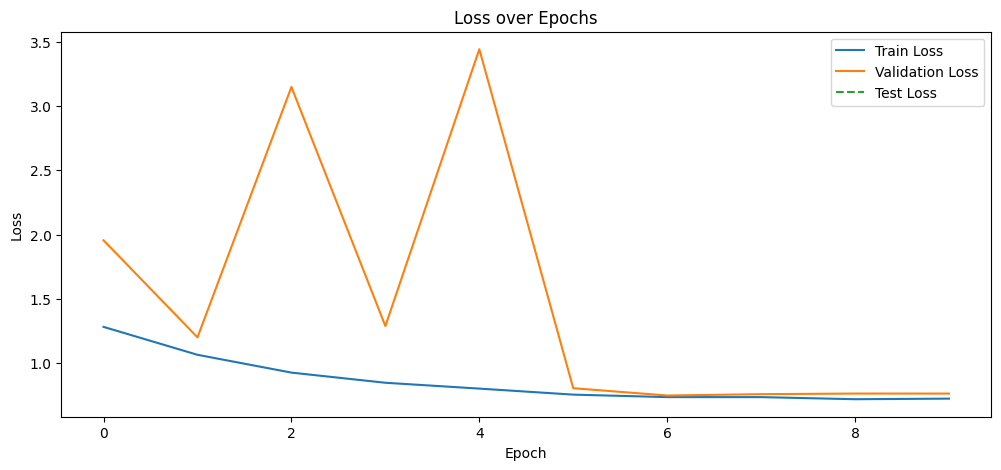

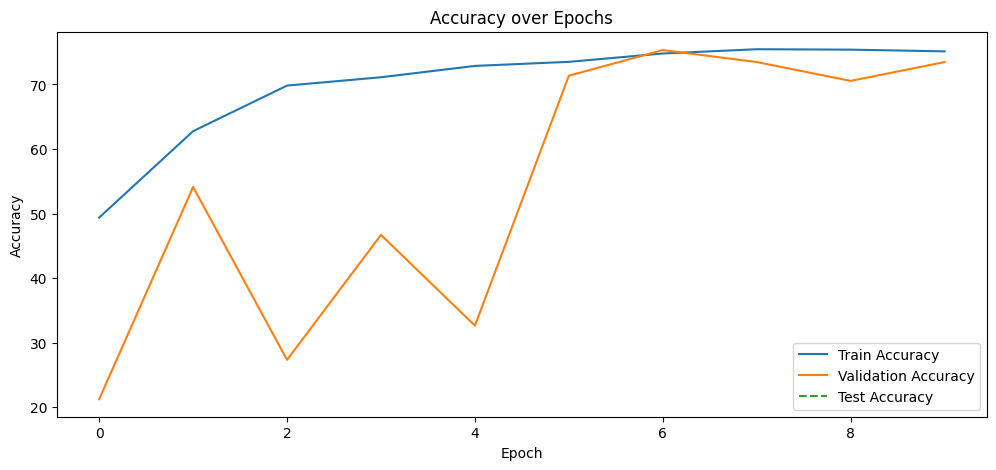

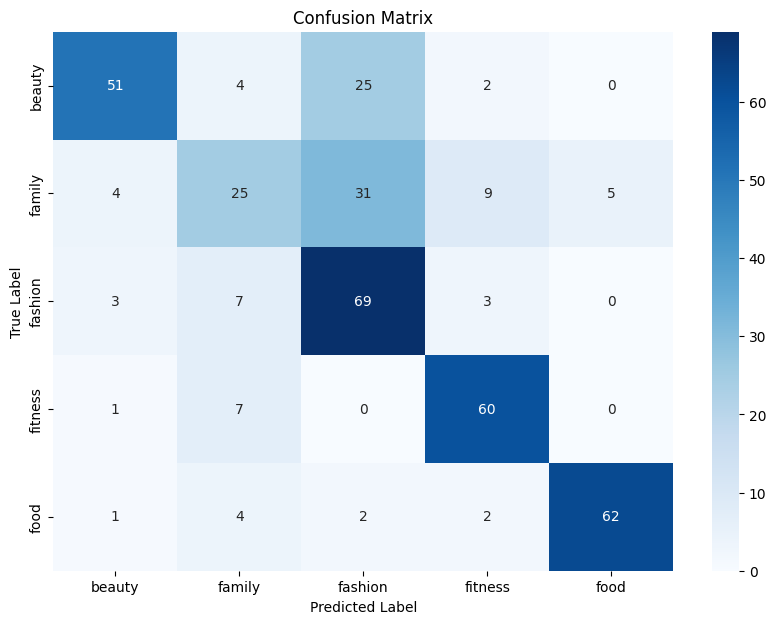

{'train_losses': [1.2813204328219097, 1.0640194863080978, 0.9253665022552013, 0.8463786393404007, 0.8008829529086748, 0.7540112336476644, 0.7346292920410633, 0.73452760775884, 0.7182071283459663, 0.7227848656475544], 'train_accuracies': [49.37002652519894, 62.765251989389924, 69.82758620689656, 71.12068965517241, 72.87798408488064, 73.5079575596817, 74.80106100795756, 75.46419098143237, 75.39787798408489, 75.13262599469496], 'val_losses': [1.955380916595459, 1.199965000152588, 3.149077216784159, 1.2878535389900208, 3.442719578742981, 0.804009199142456, 0.747051348288854, 0.7575300534566244, 0.7623307307561239, 0.7621136705080668], 'val_accuracies': [21.220159151193634, 54.11140583554376, 27.320954907161802, 46.684350132625994, 32.62599469496021, 71.35278514588859, 75.3315649867374, 73.47480106100795, 70.55702917771883, 73.47480106100795], 'test_losses': [0.7862331668535868], 'test_accuracies': [70.82228116710876]}


In [ ]:
#basic resnet(modified)
class basicblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(basicblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class basicresnet(nn.Module):
    def __init__(self, num_classes=5):
        super(basicresnet, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.resblock1 = basicblock(16, 16)
        self.resblock2 = basicblock(16, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.resblock1(x)
        x = self.resblock2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = basicresnet(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)


Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.0084050707519054 Train Accuracy: 60.41114058355438 Val Loss: 0.957389215628306 Val Accuracy: 61.80371352785146
Epoch: 2 Train Loss: 0.5297487204273542 Train Accuracy: 79.70822281167109 Val Loss: 0.7707569301128387 Val Accuracy: 69.23076923076923
Epoch: 3 Train Loss: 0.25799209740944207 Train Accuracy: 91.51193633952255 Val Loss: 0.6189129600922266 Val Accuracy: 80.10610079575596
Epoch: 4 Train Loss: 0.2060750910701851 Train Accuracy: 93.13660477453581 Val Loss: 0.35118639717499417 Val Accuracy: 86.47214854111405
Epoch: 5 Train Loss: 0.21682318672537804 Train Accuracy: 92.53978779840848 Val Loss: 0.3345908708870411 Val Accuracy: 90.45092838196287
Epoch: 6 Train Loss: 0.09917234578945984 Train Accuracy: 96.94960212201592 Val Loss: 0.3030710717042287 Val Accuracy: 91.51193633952255
Epoch: 7 Train Loss: 0.0639431775198318 Train Accuracy: 98.44164456233422 Val Loss: 0.3207085331281026 Val Accu

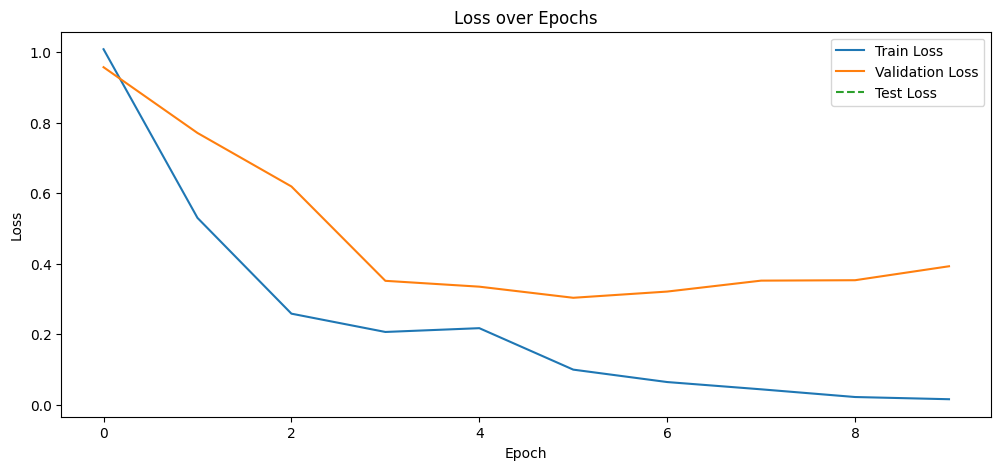

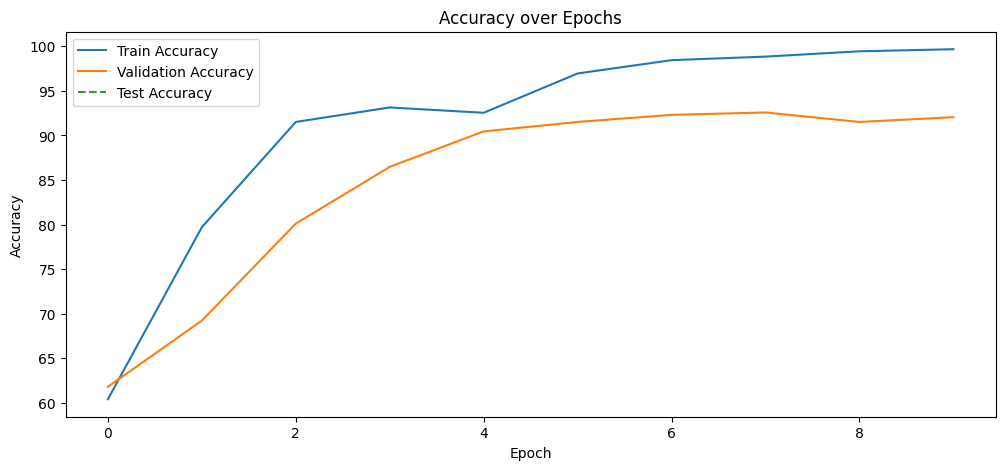

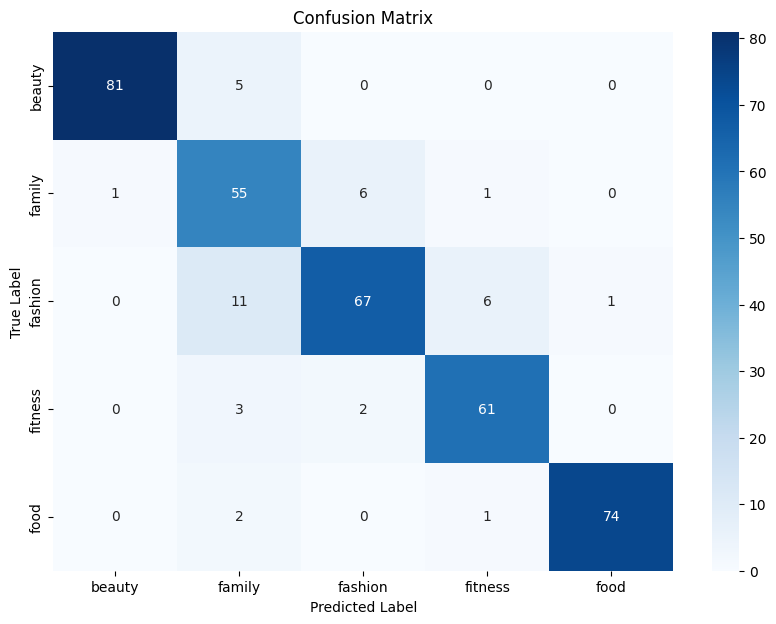

{'train_losses': [1.0084050707519054, 0.5297487204273542, 0.25799209740944207, 0.2060750910701851, 0.21682318672537804, 0.09917234578945984, 0.0639431775198318, 0.043303347997910656, 0.021448977665083174, 0.015204280270457579], 'train_accuracies': [60.41114058355438, 79.70822281167109, 91.51193633952255, 93.13660477453581, 92.53978779840848, 96.94960212201592, 98.44164456233422, 98.8395225464191, 99.43633952254642, 99.6684350132626], 'val_losses': [0.957389215628306, 0.7707569301128387, 0.6189129600922266, 0.35118639717499417, 0.3345908708870411, 0.3030710717042287, 0.3207085331281026, 0.3517342768609524, 0.35289397463202477, 0.39248913154006004], 'val_accuracies': [61.80371352785146, 69.23076923076923, 80.10610079575596, 86.47214854111405, 90.45092838196287, 91.51193633952255, 92.3076923076923, 92.57294429708223, 91.51193633952255, 92.04244031830238], 'test_losses': [0.4403265044093132], 'test_accuracies': [89.65517241379311]}
Running experiment with batch size 64, optimizer SGD, and 

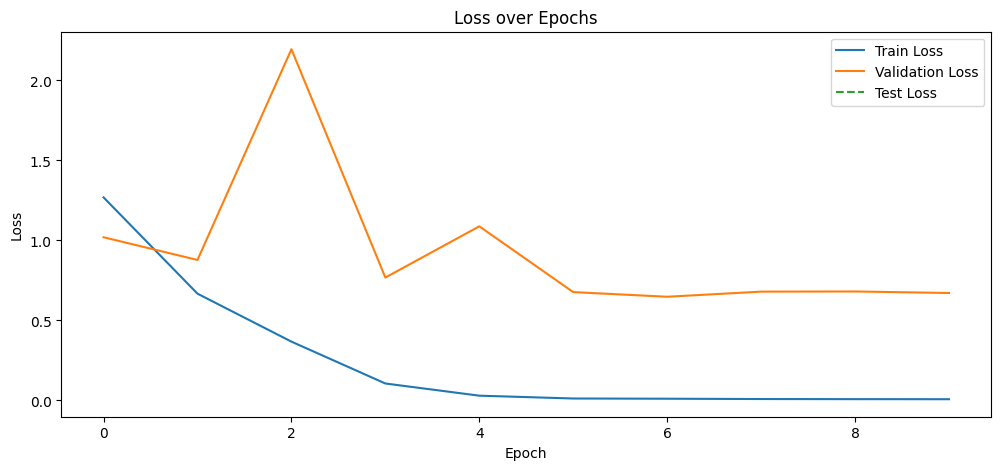

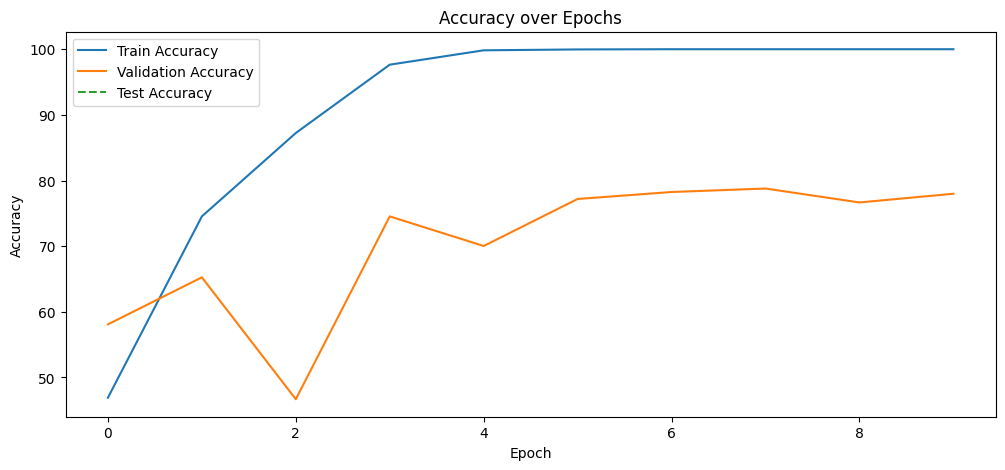

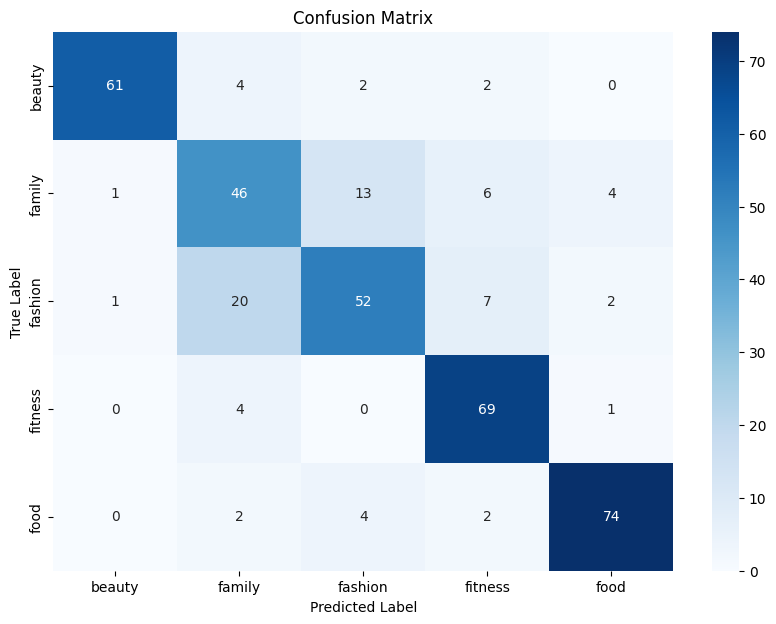

{'train_losses': [1.269028273721536, 0.6672017412881056, 0.36747013001392287, 0.10576916354087491, 0.029657859665652115, 0.011988917792526385, 0.010626183308583373, 0.008643833891255781, 0.007940495221797997, 0.007481388849555515], 'train_accuracies': [46.91644562334218, 74.53580901856763, 87.23474801061008, 97.64588859416446, 99.8342175066313, 99.96684350132627, 100.0, 100.0, 100.0, 100.0], 'val_losses': [1.0197417537371318, 0.8779532810052236, 2.1950387557347617, 0.7678904781738917, 1.0880036850770314, 0.677000160018603, 0.6479135702053705, 0.6798682063817978, 0.680951327085495, 0.6713788608709971], 'val_accuracies': [58.09018567639257, 65.25198938992042, 46.684350132625994, 74.53580901856763, 70.026525198939, 77.18832891246684, 78.24933687002653, 78.77984084880637, 76.657824933687, 77.9840848806366], 'test_losses': [0.6984109381834666], 'test_accuracies': [80.10610079575596]}
Running experiment with batch size 64, optimizer RMSprop, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.598164

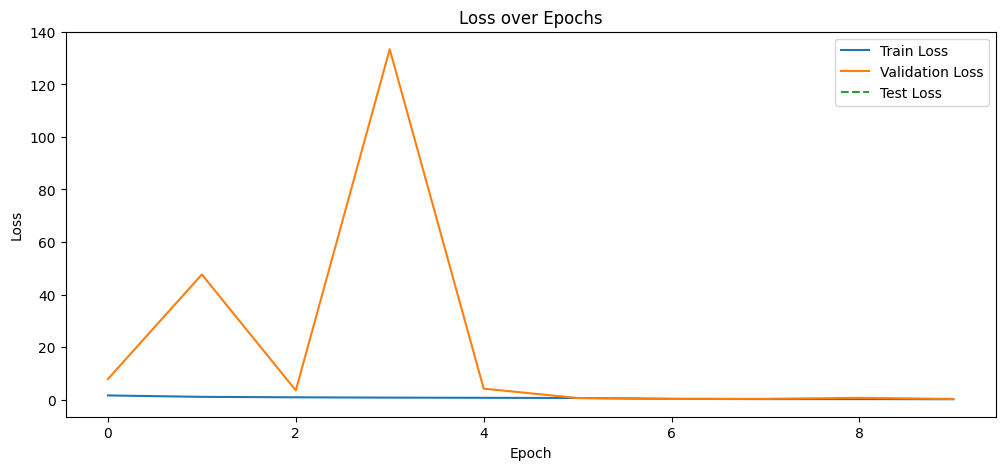

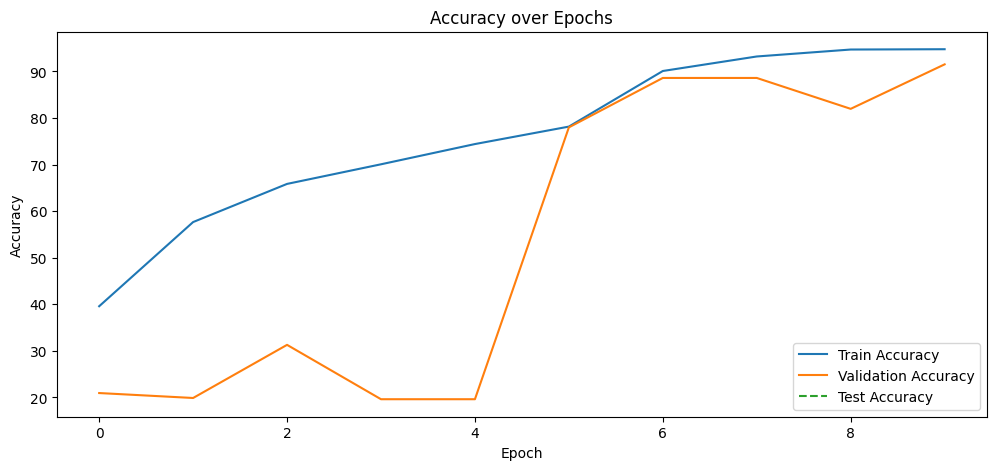

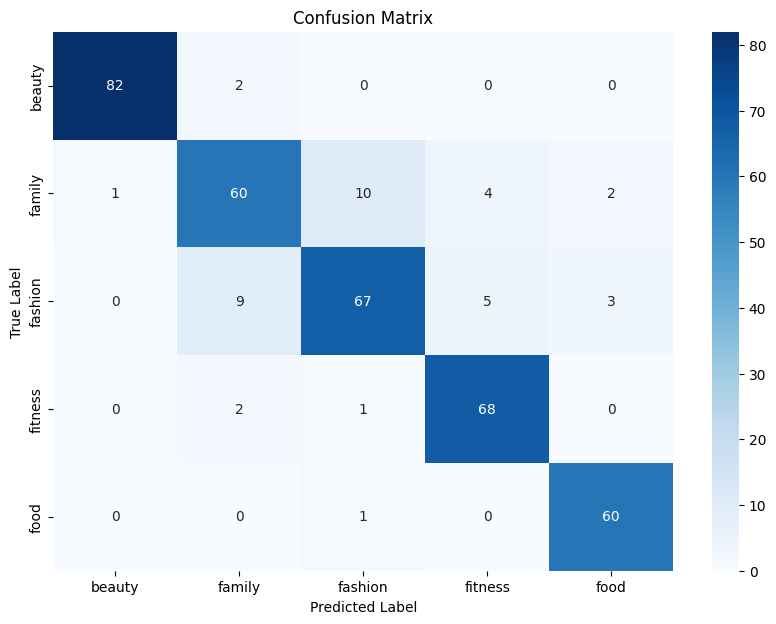

{'train_losses': [1.5981640269358952, 1.0543518873552482, 0.8851966125269731, 0.7584934594730536, 0.6954513248056173, 0.6209169713159403, 0.2889524479396641, 0.20383182230095068, 0.2003656804251174, 0.154609728914996], 'train_accuracies': [39.58885941644562, 57.65915119363395, 65.84880636604774, 70.05968169761273, 74.40318302387269, 78.14986737400531, 90.08620689655173, 93.20291777188329, 94.6949602122016, 94.76127320954907], 'val_losses': [7.817658265431722, 47.64366149902344, 3.503008762995402, 133.40235137939453, 4.183554132779439, 0.6103680034478506, 0.3005462164680163, 0.30338021119435626, 0.6772840668757757, 0.2522632032632828], 'val_accuracies': [20.954907161803714, 19.893899204244033, 31.29973474801061, 19.628647214854112, 19.628647214854112, 77.9840848806366, 88.59416445623341, 88.59416445623341, 81.96286472148542, 91.51193633952255], 'test_losses': [0.27043120687206584], 'test_accuracies': [89.38992042440319]}


In [ ]:
#restnet (modified)
class res_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(res_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class resnet(nn.Module):
    def __init__(self, num_classes=3):
        super(resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride):
        layers = [res_block(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(res_block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/My Drive/archive1'
def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = resnet(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 1.0512048788368702 Train Accuracy: 57.95755968169761 Val Loss: 1.330641855796178 Val Accuracy: 45.09283819628647
Epoch: 2 Train Loss: 0.7426249074439207 Train Accuracy: 71.75066312997347 Val Loss: 1.7555033763249714 Val Accuracy: 37.93103448275862
Epoch: 3 Train Loss: 0.37906539750595886 Train Accuracy: 87.53315649867373 Val Loss: 0.9746852219104767 Val Accuracy: 70.82228116710876
Epoch: 4 Train Loss: 0.27110736118629575 Train Accuracy: 91.57824933687003 Val Loss: 0.6697556525468826 Val Accuracy: 81.16710875331565
Epoch: 5 Train Loss: 0.2616880148028334 Train Accuracy: 92.17506631299734 Val Loss: 0.8862706820170084 Val Accuracy: 70.55702917771883
Epoch: 6 Train Loss: 0.21012146833042303 Train Accuracy: 93.53448275862068 Val Loss: 0.3447021593650182 Val Accuracy: 89.38992042440319
Epoch: 7 Train Loss: 0.16748162968239436 Train Accuracy: 94.42970822281167 Val Loss: 0.29437458515167236 Val Acc

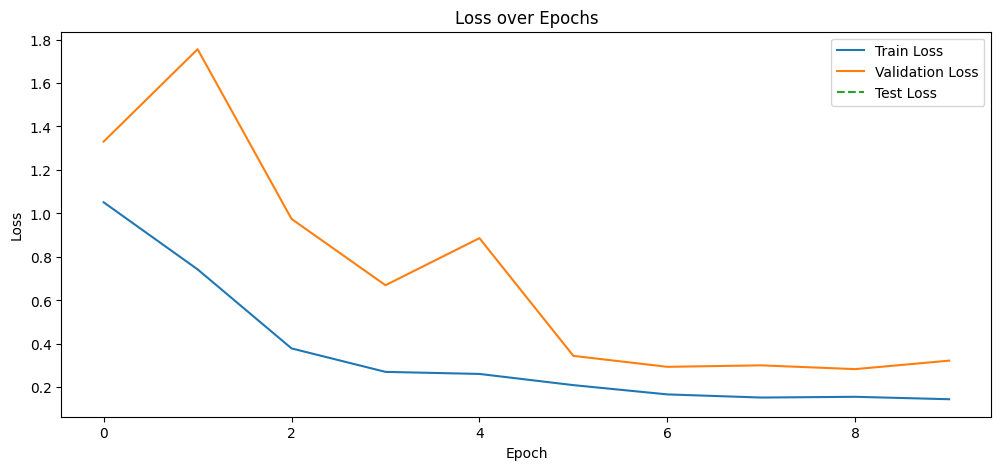

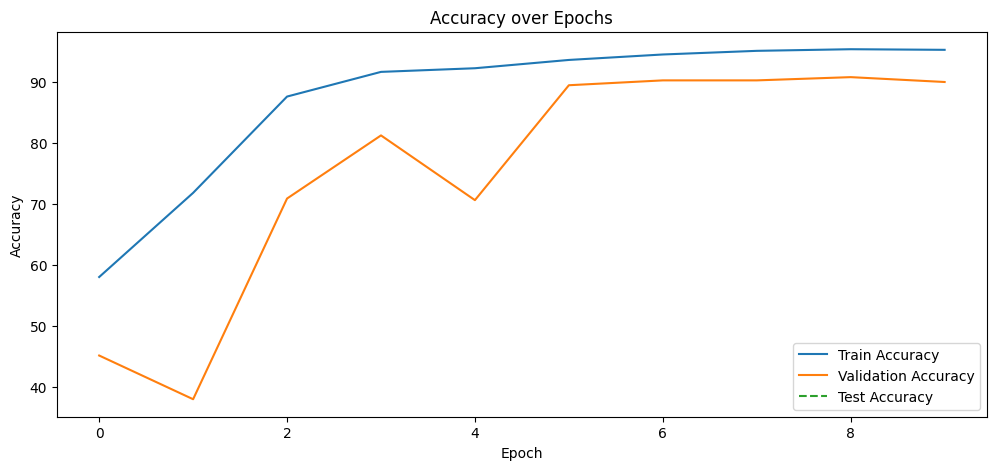

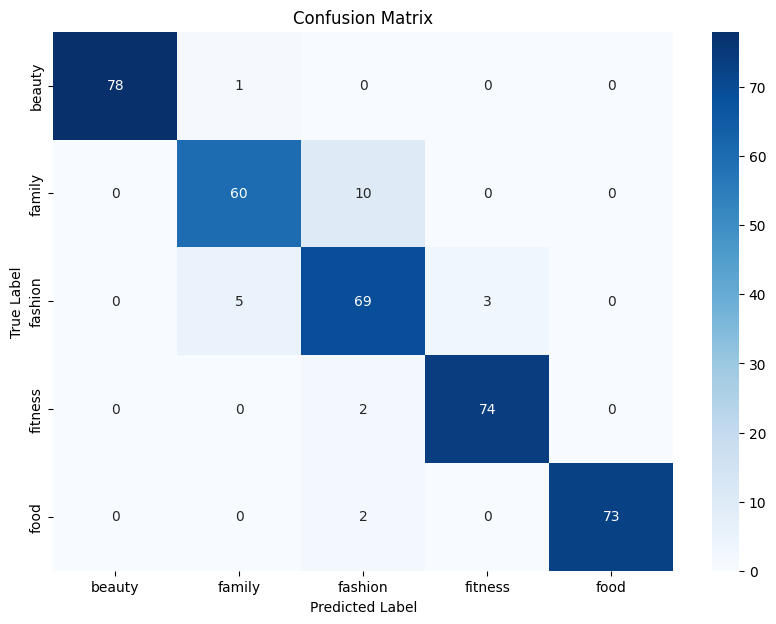

{'train_losses': [1.0512048788368702, 0.7426249074439207, 0.37906539750595886, 0.27110736118629575, 0.2616880148028334, 0.21012146833042303, 0.16748162968239436, 0.153012590482831, 0.1564421927711616, 0.14531530439853668], 'train_accuracies': [57.95755968169761, 71.75066312997347, 87.53315649867373, 91.57824933687003, 92.17506631299734, 93.53448275862068, 94.42970822281167, 95.026525198939, 95.29177718832891, 95.1923076923077], 'val_losses': [1.330641855796178, 1.7555033763249714, 0.9746852219104767, 0.6697556525468826, 0.8862706820170084, 0.3447021593650182, 0.29437458515167236, 0.3011092121402423, 0.2837573712070783, 0.32277440031369525], 'val_accuracies': [45.09283819628647, 37.93103448275862, 70.82228116710876, 81.16710875331565, 70.55702917771883, 89.38992042440319, 90.18567639257294, 90.18567639257294, 90.71618037135279, 89.92042440318302], 'test_losses': [0.2078679328163465], 'test_accuracies': [93.89920424403184]}
Running experiment with batch size 64, optimizer SGD, and L2 pen

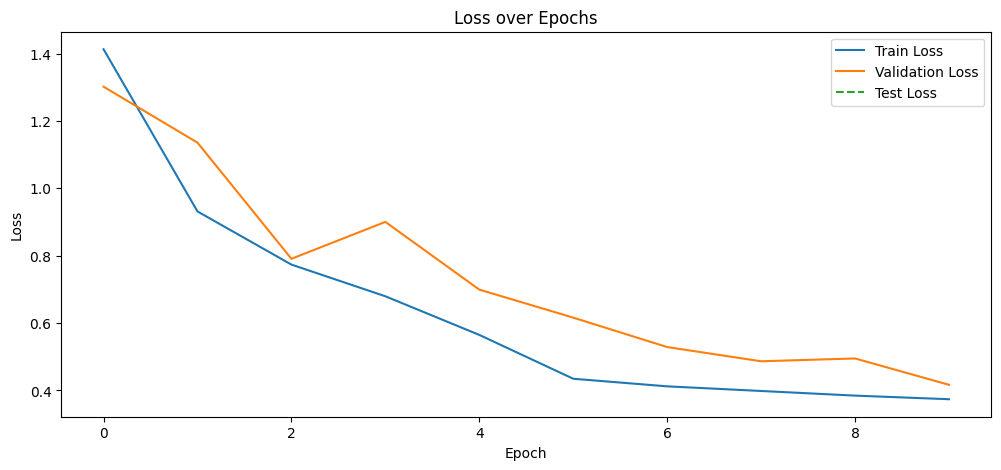

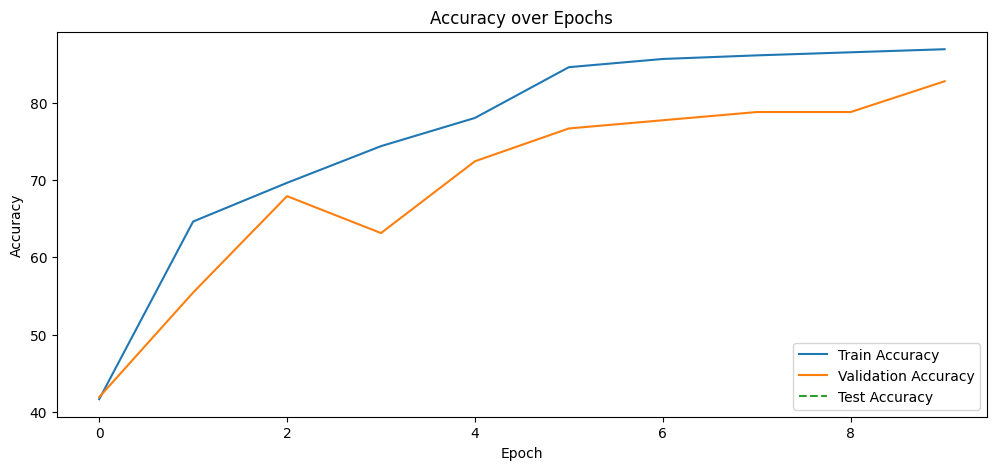

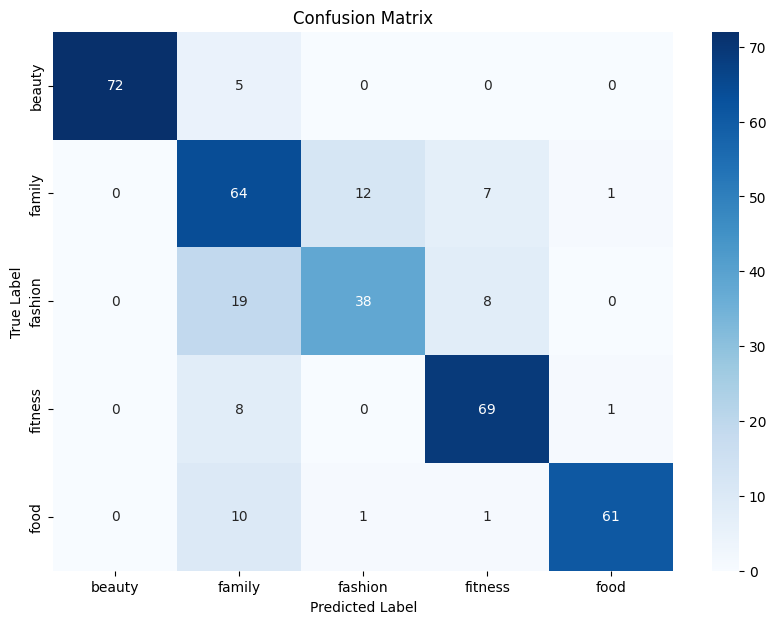

{'train_losses': [1.4129629582166672, 0.9314600564539433, 0.7737038545310497, 0.6796519042303165, 0.5650008860975504, 0.4348704144358635, 0.41232662461698055, 0.3985868642727534, 0.3848067034656803, 0.37411114914963645], 'train_accuracies': [41.644562334217504, 64.62201591511936, 69.62864721485411, 74.37002652519894, 78.01724137931035, 84.58222811671088, 85.64323607427056, 86.10742705570291, 86.5053050397878, 86.90318302387269], 'val_losses': [1.3017414808273315, 1.1356663306554158, 0.7909180720647176, 0.9004671076933543, 0.6994204223155975, 0.6162725786368052, 0.5288994113604227, 0.48677189151446026, 0.49508170286814374, 0.4169512291749318], 'val_accuracies': [41.90981432360743, 55.43766578249337, 67.90450928381964, 63.12997347480106, 72.41379310344827, 76.657824933687, 77.71883289124668, 78.77984084880637, 78.77984084880637, 82.75862068965517], 'test_losses': [0.47525928914546967], 'test_accuracies': [80.63660477453581]}
Running experiment with batch size 64, optimizer RMSprop, and L

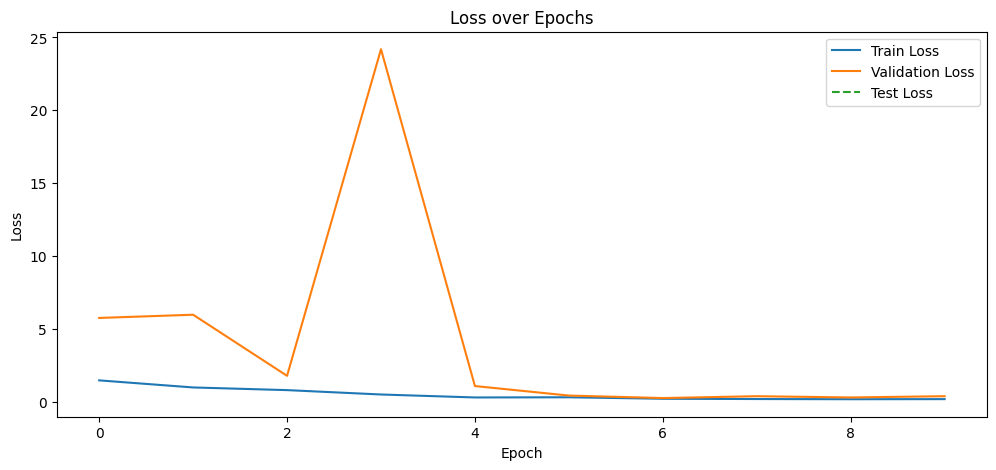

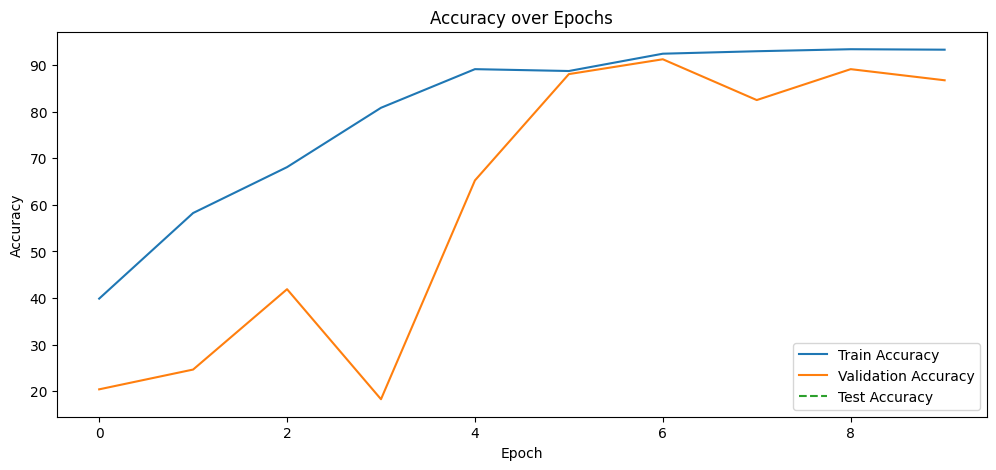

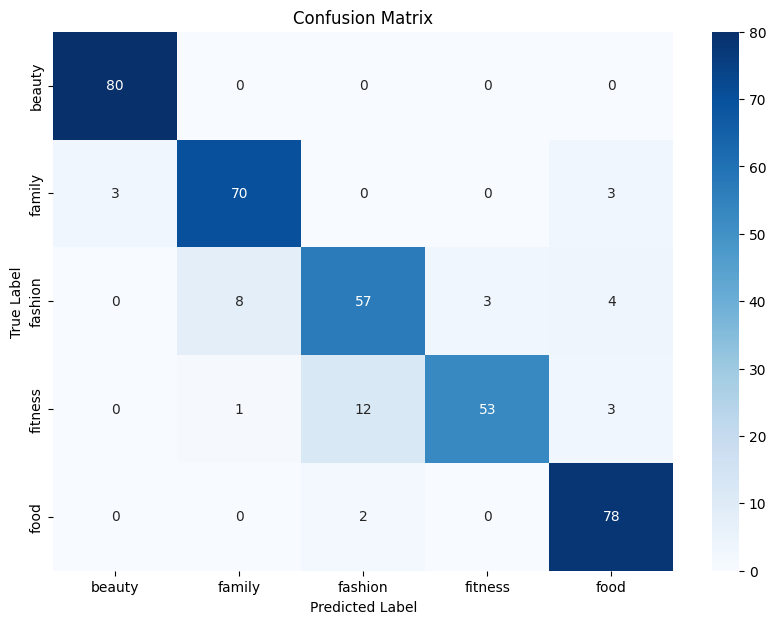

{'train_losses': [1.4898796826601028, 1.004037758956353, 0.8215418979525566, 0.5212190573414167, 0.3183257463388145, 0.33023637781540555, 0.22970328278218707, 0.20978447825958332, 0.19743919760609666, 0.20358551014214754], 'train_accuracies': [39.88726790450929, 58.255968169761275, 68.10344827586206, 80.83554376657825, 89.12466843501326, 88.72679045092838, 92.44031830238727, 92.9708222811671, 93.40185676392574, 93.3023872679045], 'val_losses': [5.769119183222453, 5.99001129468282, 1.8014148275057476, 24.190434455871582, 1.0999248325824738, 0.4474991261959076, 0.27673513690630597, 0.4038487374782562, 0.31819986800352734, 0.4043597529331843], 'val_accuracies': [20.424403183023873, 24.6684350132626, 41.90981432360743, 18.30238726790451, 65.25198938992042, 88.06366047745358, 91.24668435013263, 82.49336870026525, 89.12466843501326, 86.73740053050398], 'test_losses': [0.30583735307057697], 'test_accuracies': [89.65517241379311]}


In [ ]:
#densenet (modified)
class denselayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(denselayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(out)))
        out = self.dropout(out)
        out = torch.cat([x, out], 1)
        return out

class tl(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(tl, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = self.pool(out)
        return out

class densenet(nn.Module):
    def __init__(self, num_classes=3, growth_rate=32, block_config=(6, 12, 24, 16)):
        super(densenet, self).__init__()
        num_init_features = 2 * growth_rate
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = self._make_dense_block(denselayer, num_features, growth_rate, num_layers)
            self.features.add_module(f'denseblock{i + 1}', block)
            num_features += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = tl(num_features, num_features // 2)
                self.features.add_module(f'transition{i + 1}', trans)
                num_features = num_features // 2
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def _make_dense_block(self, block, in_channels, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(block(in_channels + i * growth_rate, growth_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = densenet(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Running experiment with batch size 64, optimizer Adam, and L2 penalty 0.001
Epoch: 1 Train Loss: 0.9435251926382383 Train Accuracy: 62.20159151193634 Val Loss: 1.8852871855099995 Val Accuracy: 40.84880636604775
Epoch: 2 Train Loss: 0.6234456660846869 Train Accuracy: 74.8342175066313 Val Loss: 0.8939257661501566 Val Accuracy: 68.96551724137932
Epoch: 3 Train Loss: 0.38721047590176266 Train Accuracy: 85.57692307692308 Val Loss: 6.936911582946777 Val Accuracy: 27.851458885941646
Epoch: 4 Train Loss: 0.27317125210538507 Train Accuracy: 90.91511936339522 Val Loss: 3.544934868812561 Val Accuracy: 39.257294429708224
Epoch: 5 Train Loss: 0.20896631960446635 Train Accuracy: 93.03713527851458 Val Loss: 0.6846150457859039 Val Accuracy: 72.94429708222812
Epoch: 6 Train Loss: 0.13568517286330462 Train Accuracy: 95.45755968169762 Val Loss: 0.2621551603078842 Val Accuracy: 89.65517241379311
Epoch: 7 Train Loss: 0.11359360922748844 Train Accuracy: 96.48541114058355 Val Loss: 0.23827587813138962 Val Ac

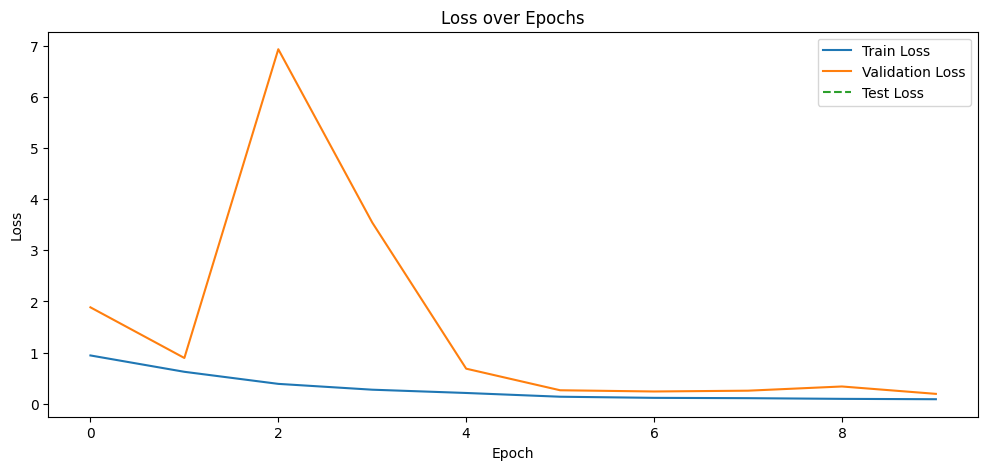

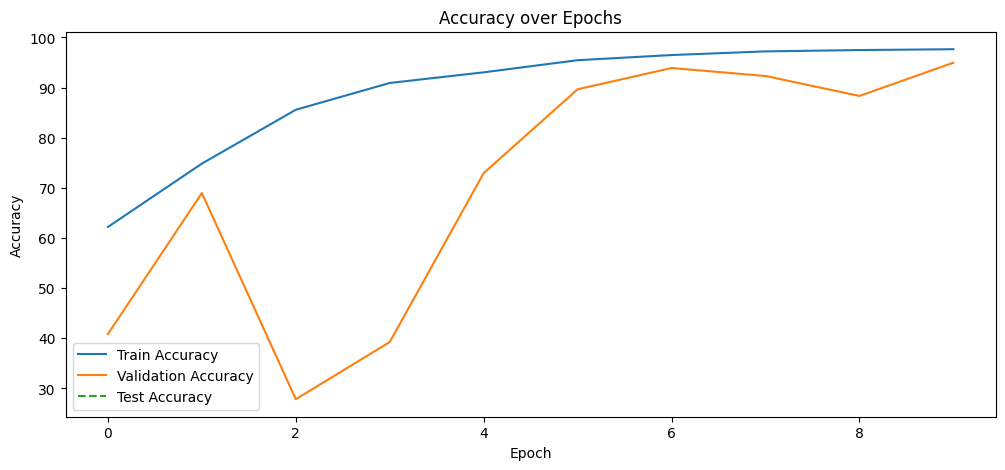

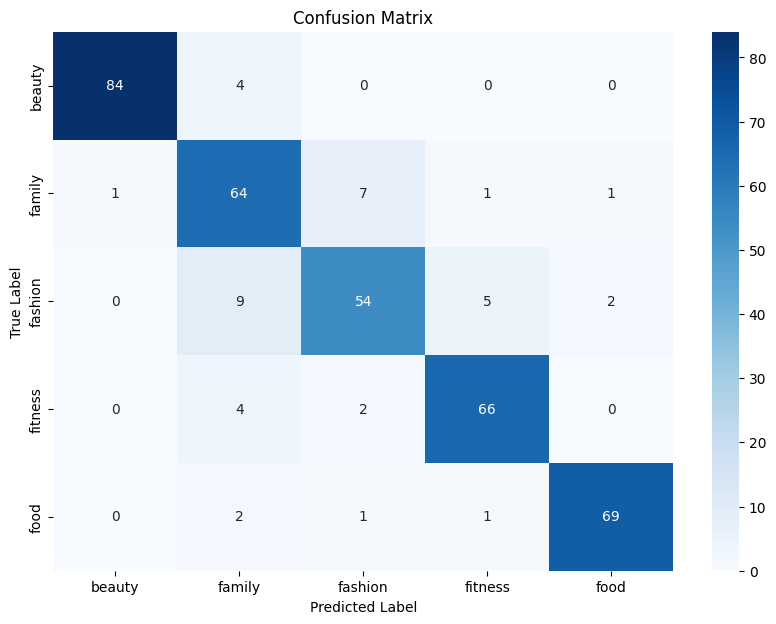

{'train_losses': [0.9435251926382383, 0.6234456660846869, 0.38721047590176266, 0.27317125210538507, 0.20896631960446635, 0.13568517286330462, 0.11359360922748844, 0.10731159592978656, 0.0939552765339613, 0.0867756218649447], 'train_accuracies': [62.20159151193634, 74.8342175066313, 85.57692307692308, 90.91511936339522, 93.03713527851458, 95.45755968169762, 96.48541114058355, 97.21485411140584, 97.48010610079575, 97.64588859416446], 'val_losses': [1.8852871855099995, 0.8939257661501566, 6.936911582946777, 3.544934868812561, 0.6846150457859039, 0.2621551603078842, 0.23827587813138962, 0.25386688361565274, 0.3360920349756877, 0.19169040645162264], 'val_accuracies': [40.84880636604775, 68.96551724137932, 27.851458885941646, 39.257294429708224, 72.94429708222812, 89.65517241379311, 93.89920424403184, 92.3076923076923, 88.3289124668435, 94.96021220159152], 'test_losses': [0.3201165050268173], 'test_accuracies': [89.38992042440319]}
Running experiment with batch size 64, optimizer SGD, and L2

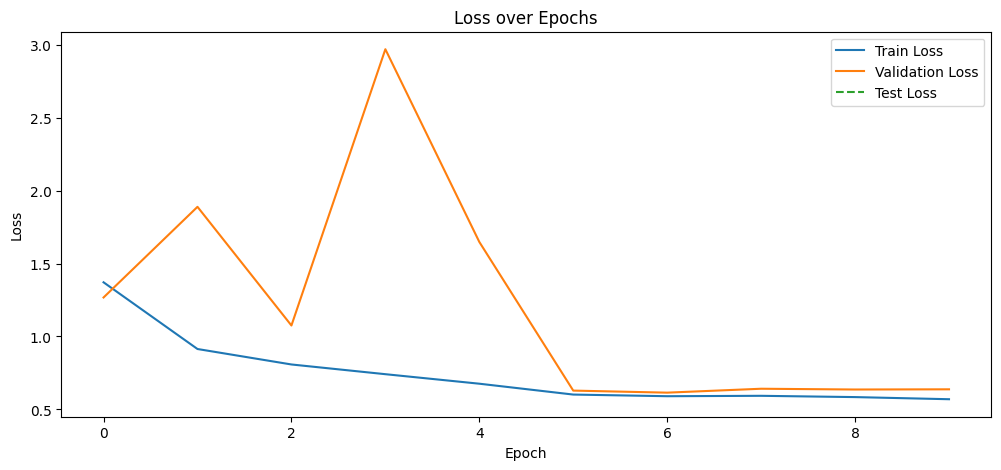

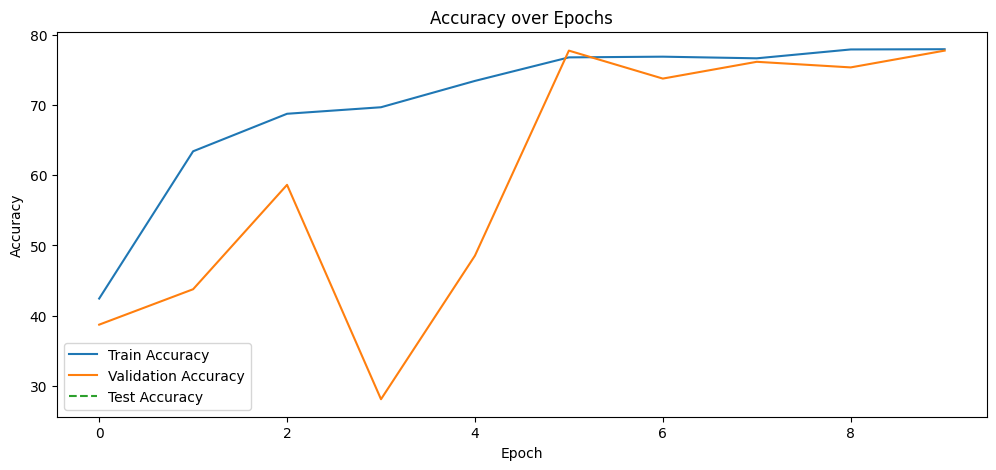

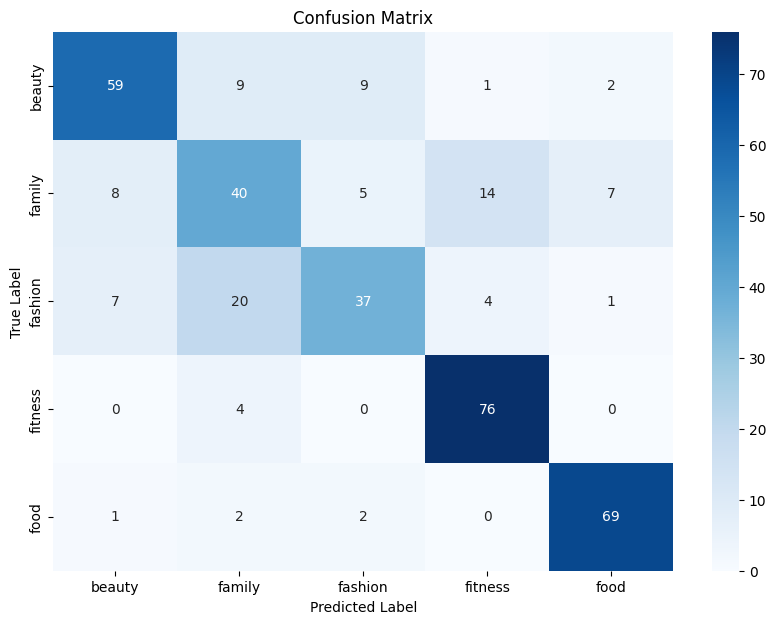

{'train_losses': [1.3713436275720596, 0.9141075561443964, 0.8081180068353812, 0.7414946562300125, 0.6762648510436217, 0.6018338731179634, 0.5905461671451727, 0.5933043205489715, 0.5845034463951985, 0.5699135518322388], 'train_accuracies': [42.44031830238727, 63.39522546419098, 68.73342175066313, 69.66180371352785, 73.40848806366047, 76.75729442970822, 76.85676392572944, 76.62466843501326, 77.88461538461539, 77.91777188328912], 'val_losses': [1.267308513323466, 1.8886872331301372, 1.075254112482071, 2.9690248568852744, 1.6481954455375671, 0.6290055761734644, 0.6149542182683945, 0.6417578409115473, 0.6364567925532659, 0.637838621934255], 'val_accuracies': [38.726790450928384, 43.76657824933687, 58.62068965517241, 28.116710875331567, 48.54111405835544, 77.71883289124668, 73.74005305039788, 76.12732095490716, 75.3315649867374, 77.71883289124668], 'test_losses': [0.6216643949349722], 'test_accuracies': [74.53580901856763]}
Running experiment with batch size 64, optimizer RMSprop, and L2 pen

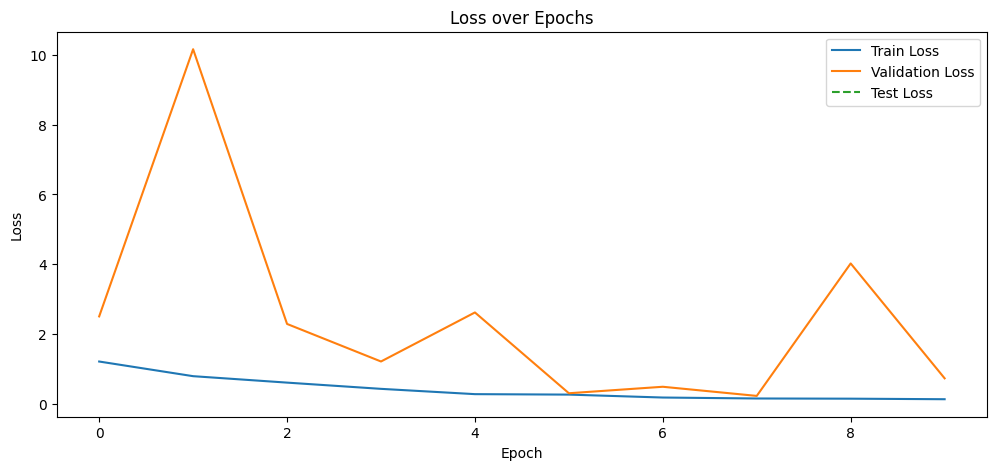

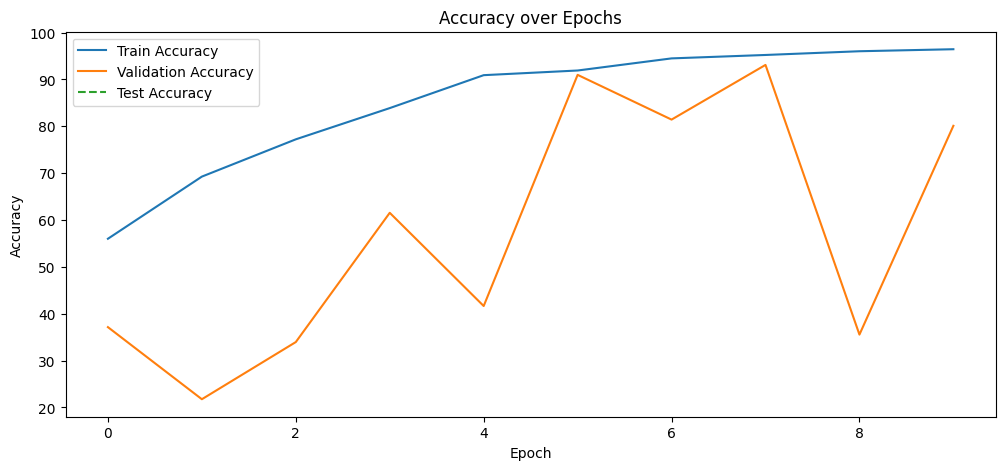

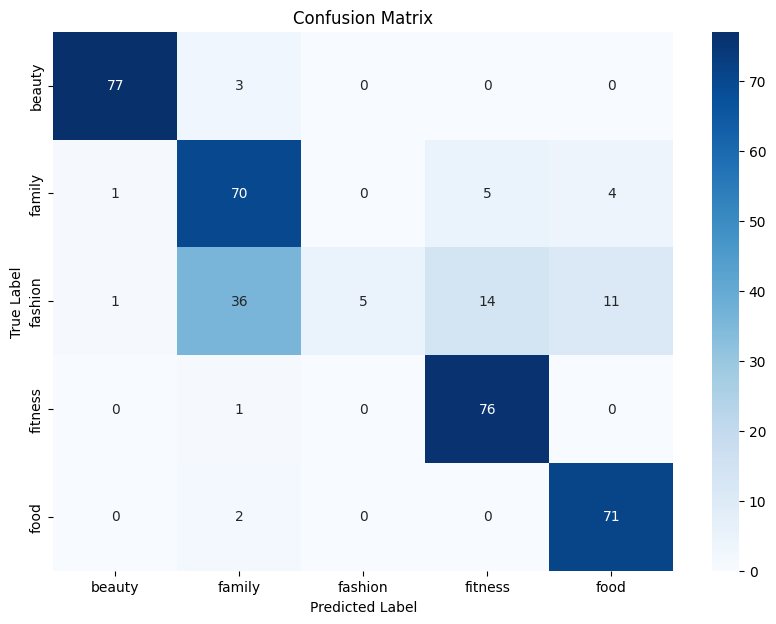

{'train_losses': [1.2108735131720703, 0.7908170533676943, 0.6062468457967043, 0.4276426586632927, 0.2757841196532051, 0.2626449068387349, 0.1788376740490397, 0.1513952713770171, 0.14592314915110668, 0.13032541602539519], 'train_accuracies': [56.00132625994695, 69.26392572944297, 77.22148541114058, 83.88594164456234, 90.91511936339522, 91.90981432360742, 94.49602122015915, 95.22546419098143, 96.0212201591512, 96.45225464190982], 'val_losses': [2.5041147470474243, 10.162158648173014, 2.288001616795858, 1.2118092974026997, 2.6174666484196982, 0.301636869708697, 0.4873153070608775, 0.22543273493647575, 4.022219141324361, 0.7290659695863724], 'val_accuracies': [37.13527851458886, 21.750663129973475, 33.95225464190982, 61.53846153846154, 41.644562334217504, 90.9814323607427, 81.43236074270557, 93.10344827586206, 35.54376657824934, 80.10610079575596], 'test_losses': [0.6812001715103785], 'test_accuracies': [79.3103448275862]}


In [ ]:
#GoogleNet (modified)
class support(nn.Module):
    def __init__(self, in_ch, b1_out, b3_red, b3_out, b5_red, b5_out, pool_proj):
        super(support, self).__init__()
        self.b1x1 = nn.Conv2d(in_ch, b1_out, kernel_size=1)
        self.bn_b1 = nn.BatchNorm2d(b1_out)
        self.b3x3 = nn.Sequential(
            nn.Conv2d(in_ch, b3_red, kernel_size=1),
            nn.BatchNorm2d(b3_red),
            nn.ReLU(inplace=True),
            nn.Conv2d(b3_red, b3_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(b3_out),
            nn.ReLU(inplace=True)
        )
        self.b5x5 = nn.Sequential(
            nn.Conv2d(in_ch, b5_red, kernel_size=1),
            nn.BatchNorm2d(b5_red),
            nn.ReLU(inplace=True),
            nn.Conv2d(b5_red, b5_out, kernel_size=5, padding=2),
            nn.BatchNorm2d(b5_out),
            nn.ReLU(inplace=True)
        )
        self.bpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        branch1x1 = self.bn_b1(self.b1x1(x))
        branch3x3 = self.b3x3(x)
        branch5x5 = self.b5x5(x)
        branch_pool = self.bpool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

class googlenet(nn.Module):
    def __init__(self, num_classes=5):
        super(googlenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_conv1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn_conv2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = support(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = support(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.bn_conv1(self.conv1(x))))
        x = self.maxpool2(F.relu(self.bn_conv2(self.conv2(x))))
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def run_experiment(batch_size, optimizer_name, l2_pen, device):
    train_loader, val_loader, test_loader, dataset = load_data(data_dir, batch_size=batch_size)
    model = googlenet(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_pen)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=l2_pen)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=l2_pen)

    train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, true_labels, pred_labels = train_test(
        train_loader, val_loader, test_loader, model, optimizer, criterion, device)

    plotting(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, true_labels, pred_labels, dataset)

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_sizes = [64]
optimizer_types = ['Adam', 'SGD', 'RMSprop']
l2_pen = 0.001

for batch_size in batch_sizes:
    for optimizer_type in optimizer_types:
        print(f"Running with batch size {batch_size}, optimizer {optimizer_type}, and L2 {l2_pen}")
        experiment_results = run_experiment(batch_size, optimizer_type, l2_pen, device)
        print(experiment_results)

Using device: cuda
Epoch 1, Loss: 1.0310755968093872
Epoch 2, Loss: 0.9905276894569397
Epoch 3, Loss: 1.0129388570785522
Epoch 4, Loss: 1.0138262510299683
Epoch 5, Loss: 1.0142451524734497
Similar image is at archive1/food/acozykitchen.jpg with a distance of 3.9543662071228027


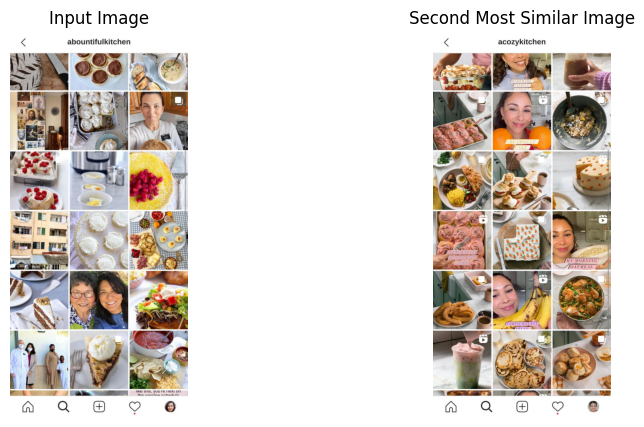

In [ ]:
#Siamese Network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class feature_ext(nn.Module):
    def __init__(self):
        super(feature_ext, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.dilated_conv = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 512)

    def forward(self, x):
        x = self.features(x)
        x = self.dilated_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class sim_network(nn.Module):
    def __init__(self):
        super(sim_network, self).__init__()
        self.cnn = feature_ext().to(device)

    def forward(self, img1, img2):
        output1 = self.cnn(img1)
        output2 = self.cnn(img2)
        output1 = nn.functional.normalize(output1, p=2, dim=1)
        output2 = nn.functional.normalize(output2, p=2, dim=1)
        distance = torch.sqrt(torch.sum((output1 - output2) ** 2, dim=1))
        return distance

class sim_data(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = datasets.ImageFolder(image_folder)
        self.transform = transform

    def __getitem__(self, index):
        img1, label1 = self.image_folder[index]
        if np.random.rand() > 0.5:
            same_class_idx = np.random.choice([i for i, t in enumerate(self.image_folder.targets) if t == label1])
        else:
            different_class_idx = np.random.choice([i for i, t in enumerate(self.image_folder.targets) if t != label1])
            same_class_idx = different_class_idx
        img2, label2 = self.image_folder[same_class_idx]
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1.to(device), img2.to(device), torch.tensor([int(label1 == label2)], dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.image_folder)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class loss_fun(nn.Module):
    def __init__(self, margin=2.0):
        super(loss_fun, self).__init__()
        self.margin = margin

    def forward(self, distance, label):
        loss = (1 - label) * torch.pow(distance, 2) + (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        return loss.mean()

def train(network, data_loader, epochs=5):
    criterion = loss_fun().to(device)
    optimizer = optim.SGD(network.parameters(), lr=0.01)

    for epoch in range(epochs):
        for img1, img2, labels in data_loader:
            optimizer.zero_grad()
            distances = network(img1, img2).view(-1)
            labels = labels.view(-1).float()
            loss = criterion(distances, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

sim_data = sim_data('archive1', transform=transform)
data_loader = DataLoader(sim_data, batch_size=64, shuffle=True)

sim_network = sim_network()
train(sim_network, data_loader)
torch.save(sim_network.state_dict(), 'siamese_network.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    display_image = image.copy()
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image, display_image

def simliar_images(network, dataset, test_image_path, transform):
    test_image, test_display_image = load_image(test_image_path, transform)
    min_distance = float('inf')
    second_min_distance = float('inf')
    most_similar_image_path = None
    sim_image = None

    network.eval().to(device)
    with torch.no_grad():
        test_image_features = network.cnn(test_image).squeeze(0)
        for img_path, _ in dataset.image_folder.imgs:
            img, _ = load_image(img_path, transform)
            img_features = network.cnn(img).squeeze(0)
            distance = torch.sqrt(torch.sum((test_image_features - img_features) ** 2)).item()
            if distance < min_distance:
                second_min_distance = min_distance
                sim_image = most_similar_image_path
                min_distance = distance
                most_similar_image_path = img_path
            elif distance < second_min_distance:
                second_min_distance = distance
                sim_image = img_path
    return sim_image, second_min_distance, test_display_image, Image.open(sim_image).convert('RGB')

test_image_path = 'abountifulkitchen.jpg'
sim_image, distance, test_display_image, similar_display_image = simliar_images(sim_network, sim_data, test_image_path, transform)
print(f"Similar image is at {sim_image} with a distance of {distance}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_display_image)
ax[0].set_title('Input Image')
ax[0].axis('off')

ax[1].imshow(similar_display_image)
ax[1].set_title('Second Most Similar Image')
ax[1].axis('off')
plt.show()